In [1]:
# =========================================================================== #
#                       |Importation des lib/packages|                        #
# =========================================================================== #
# --- librairies standards --- #
import pandas as pd
import numpy as np
import sys

# --- librairies locales --- #
import tinystatistician as tinystat
from my_logistic_regression import MyLogisticRegression as mylogr
from my_logistic_regression import MyLogisticRegressionWithHistory as mylogrwh
from my_logistic_regression import MyLogisticMetrics as mylogrmetrics
from parsing import parser
from utils import *
from utils_graphic import *

In [2]:
# =========================================================================== #
#                        | Definition des constantes|                         #
# =========================================================================== #

# Les series d'intérêt dans le dataset de train ou de test sont les clefs du dct
# suivant. Nous fixons le type de ces series
dct_types = {"Arithmancy" : np.float32, "Astronomy" : np.float32,
             "Herbology" : np.float32, "Defense Against the Dark Arts" : np.float32,
             "Divination" : np.float32, "Muggle Studies" : np.float32,
             "Ancient Runes" : np.float32, "History of Magic" : np.float32,
             "Transfiguration" : np.float32, "Potions" : np.float32,
             "Care of Magical Creatures" : np.float32, "Charms" : np.float32,
             "Flying" : np.float32}

# -- values to predict -- #
target = "Hogwarts House"

# -- features used in the models -- #
#lst_features = ["Arithmancy", "Herbology", "Defense Against the Dark Arts", "Divination",
#					"Muggle Studies", "Ancient Runes", "History of Magic",
#					"Transfiguration", "Potions", "Care of Magical Creatures",
#					"Charms", "Flying"]
lst_features = ["Defense Against the Dark Arts", "Herbology", "Divination",
                "Ancient Runes", "History of Magic"]

# -- training / dev set ratio -- #
split_ratio = 0.7

# =========================================================================== #
#                 |importation des fonctions de logreg_train|                 #
# =========================================================================== #
from logreg_train import score_report

# Retrieve and formating the dataset for training:

In [3]:
datapath = "datasets/dataset_train.csv"

# -- Reading of the data from the csv file dedicated for the training
df = open_read_file(datapath, "train")

In [4]:
# -- Replacing the missing value by the mean
df.fillna(df.mean(),inplace=True)
nb_features = len(lst_features)
df_m1 = df[lst_features + [target]].copy()

In [5]:
df_raw = df[lst_features + [target]].copy()
df_raw = df_raw.sample(frac = 1)

df_raw_train = df_raw[:int(split_ratio * df_raw.shape[0])]
df_raw_dev = df_raw[int(split_ratio * df_raw.shape[0]):]

In [6]:
# -- Standardization of the numerical data in the differents
tinystat.standardization(df_m1)

Series which are not of dtype np.float32 will be ignored.


In [7]:
# -- Shuffling and splitting data into train and dev sets
df_m1 = df_m1.sample(frac = 1)
df_train = df_m1[:int(split_ratio * df_m1.shape[0])]
df_dev = df_m1[int(split_ratio * df_m1.shape[0]):]

In [8]:
# ==== ==
# Separation of x and y data of the training set
# and preparation of the target of each classifiers
# ==== ==
x_train = df_train[lst_features].copy()
y_train = df_train[[target]].copy()

y_train[["target clf1", "target clf2", "target clf3", "target clf4"]]= 0
y_train.loc[y_train[target] == "Gryffindor", "target clf1"] = 1
y_train.loc[y_train[target] == "Slytherin", "target clf2"] = 1
y_train.loc[y_train[target] == "Ravenclaw", "target clf3"] = 1
y_train.loc[y_train[target] == "Hufflepuff", "target clf4"] = 1

In [9]:
# ==== ==
# Separation of x and y data of the dev set
# and preparation of the target of each classifiers
# ==== ==
x_dev = df_dev[lst_features].copy()
y_dev = df_dev[[target]].copy()

y_dev[["target clf1", "target clf2", "target clf3", "target clf4"]]= 0
y_dev.loc[y_dev[target] == "Gryffindor", "target clf1"] = 1
y_dev.loc[y_dev[target] == "Slytherin", "target clf2"] = 1
y_dev.loc[y_dev[target] == "Ravenclaw", "target clf3"] = 1
y_dev.loc[y_dev[target] == "Hufflepuff", "target clf4"] = 1

In [10]:
# ==== ==
# Separation of x and y data of the training set
# and preparation of the target of each classifiers
# ==== ==
x_raw_train = df_raw_train[lst_features].copy()

x_raw_dev = df_raw_dev[lst_features].copy()

In [11]:
x_train.head(5)

,Defense Against the Dark Arts,Herbology,Divination,Ancient Runes,History of Magic
1039,-5.261151e-01,-0.707709,0.014269,3.685121e-01,-0.985802
1337,-2.095623e-01,0.473236,-0.072009,-2.874427e-01,-0.246950
503,-2.887597e-09,0.510038,-0.019609,-4.592963e-01,-0.035100
1436,5.121261e-01,-0.750790,-0.903589,-5.619273e-01,0.557501
1180,4.113078e-01,-0.618576,-1.176680,2.904150e-07,-0.007158


In [12]:
y_train.head(5)

,Hogwarts House,target clf1,target clf2,target clf3,target clf4
1039,Gryffindor,1,0,0,0
1337,Hufflepuff,0,0,0,1
503,Hufflepuff,0,0,0,1
1436,Slytherin,0,1,0,0
1180,Slytherin,0,1,0,0


Nous avons maintenant 4 datasets:
* le dataset standardisé d'entraînement (**x_train**)
* le dataset standardisé de test pour l'évaluation des performances (**x_dev**),
* le dataset non standardisé d'entraînment (**x_raw_train**),
* le dataset non standardisé de test pour l'évaluation des performances (**x_raw_dev**),

Dans **y_train** nous pouvons observer que l'on a ajouté les colonnes *"target clf1"*, *"target clf2"*, *"target clf3"* et *"target clf4"* qui peuvent prendre uniquement $0$ ou $1$ comme valeur.
Cet étape sera utile pour comparer les prédictions de chaque classifiers binaires avec les résultats attendus, ainsi que pour évaluer les valeurs des différentes métriques sur le dataset de test. 

---

---

# Utilisation basique (partie obligatoire)

## Initialiastion/instanciation des modèles:

In [13]:
# ==== ==
# Declaration and initialization of the logistic classifiers
# ==== ==


# Liste des méthodes possible:
# * "GD" = Gradient descent,
# * "SGD" = stochastic gradient descent,
# * "SGD+momentum" = stochastic gradient descent with momentum,
# * "minibatch" gradient descent avec minibatch

mode = "basic"
# Le mode permet d'utiliser un modèle "basique" ou un modèle avec "historique"
if mode == "basic":
	model = mylogr
if mode == "history":
	model = mylogrwh

clf1 = model(np.random.rand(nb_features, 1), alpha=1e-2, max_iter=10000, lambd=0.0, tag="Gryffindor", method="GD")
clf2 = model(np.random.rand(nb_features, 1), alpha=1e-2, max_iter=10000, lambd=0.0, tag="Slytherin", method="GD")
clf3 = model(np.random.rand(nb_features, 1), alpha=1e-2, max_iter=10000, lambd=0.0, tag="Ravenclaw", method="GD")
clf4 = model(np.random.rand(nb_features, 1), alpha=1e-2, max_iter=10000, lambd=0.0, tag="Hufflepuff", method="GD")
clfs = [clf1, clf2, clf3, clf4]

En fonction du modèle, l'appelle à la procédure d'entraînement diffère légèrement.
Dans le cas où les modèles de classification utilisent les méthodes "GD", "SGD" ou "SGD+momentum", la méthode ```fit_``` de chaque classifiers peuvent être appelé directement.
Quand les modèles de classifications utilisent la méthode "minibatch", il faut au préalable générer les batches de données avant de pouvoir appeler la méthode ```fit_``` des classifiers.

## Entraînement des classifiers binaires:

In [14]:
# ==== ==
# Fitting process for all logistic classifiers
# ==== ==
i = 1
# --- For "GD", "SGD" and "SGD+momentum"
for clf in clfs:
    if mode == "history":
        clf.fit_history_(x_train.values, y_train[f"target clf{i}"].values.reshape(-1,1))
    else:
        clf.fit_(x_train.values, y_train[f"target clf{i}"].values.reshape(-1,1))
    i += 1

## Évaluation des classifiers:

### Coût des classifiers:

In [15]:
print("valeur du cout du clf 1: ", clf1.cost_(x_train, y_train['target clf1'].values.reshape(-1,1))[0])
print("valeur du cout du clf 2: ", clf2.cost_(x_train, y_train['target clf2'].values.reshape(-1,1))[0])
print("valeur du cout du clf 3: ", clf3.cost_(x_train, y_train['target clf3'].values.reshape(-1,1))[0])
print("valeur du cout du clf 4: ", clf4.cost_(x_train, y_train['target clf4'].values.reshape(-1,1))[0])

valeur du cout du clf 1:  0.060828282021414076
valeur du cout du clf 2:  0.05565049836555244
valeur du cout du clf 3:  0.07997508487377178
valeur du cout du clf 4:  0.08411396245952404


### Préparation du dataframe pour la partie score des modèles:

In [16]:
df_res = y_train.copy()

In [17]:
df_res["pred clf1"] = clf1.predict_(x_train.values)
df_res["pred clf2"] = clf2.predict_(x_train.values)
df_res["pred clf3"] = clf3.predict_(x_train.values)
df_res["pred clf4"] = clf4.predict_(x_train.values)

In [18]:
df_res = df_res.reindex(columns=["Hogwarts House", "target clf1", "pred clf1",
                                 "target clf2", "pred clf2",
                                 "target clf3", "pred clf3",
                                 "target clf4", "pred clf4"])

pred_name = ["pred clf1", "pred clf2", "pred clf3", "pred clf4"]
dct_pred = {"pred clf1":"Gryffindor",
            "pred clf2":"Slytherin",
            "pred clf3":"Ravenclaw",
            "pred clf4":"Hufflepuff"}

s_pred_label = df_res[pred_name].idxmax(axis="columns").replace(to_replace=dct_pred)
df_res["predicted Hogwarts House"] = s_pred_label

In [19]:
df_res.head(5)

,Hogwarts House,target clf1,pred clf1,target clf2,pred clf2,target clf3,pred clf3,target clf4,pred clf4,predicted Hogwarts House
1039,Gryffindor,1,0.968492,0,0.026194,0,0.005507,0,0.022327,Gryffindor
1337,Hufflepuff,0,0.044203,0,0.032424,0,0.039075,1,0.699695,Hufflepuff
503,Hufflepuff,0,0.011712,0,0.058249,0,0.070210,1,0.759236,Hufflepuff
1436,Slytherin,0,0.006221,1,0.973474,0,0.020944,0,0.035683,Slytherin
1180,Slytherin,0,0.070083,1,0.936798,0,0.031819,0,0.003880,Slytherin


### Précision, accuracy, recall et F1 score:

In [20]:
score_report(df_res, ["accuracy", "precision", "recall", "F1"])


Score metrics report:
             accuracy  precision  recall      F1   size
Gryffindor    0.9920     0.9913  0.9702  0.9806  230.0
Slytherin     0.9946     0.9952  0.9765  0.9858  209.0
Ravenclaw     0.9902     0.9774  0.9870  0.9822  310.0
Hufflepuff    0.9911     0.9784  0.9945  0.9864  371.0


---

---

# Influence de la méthode d'optimisation sur les performance des différents modèles:

Nous comparons les performances des classifieurs binaires en fonction de la méthode d'optimisation permettant de mettre à jour les valeurs des coefficients.
Pour cela, nous itinialisons 4 modèles pour chacune des classes présentes.

Les modèles possèdent des paramètres identiques (*learning rate*, coefficient de normalisation, maximum d'itérations) sauf pour la méthode utilisée.
4 méthodes d'optimisations sont possibles:
* la descente de gradient (**GD**) (obligatoire),
* la descente de gradient stochastique (**SGD**) (bonus),
* la descente de gradient avec des petits batch de données (**minibatch**) (bonus),
* la descente de gradient stochastique avec moment d'inertie (**SGDm**) (bonus).

Pour une classe donnée, les 4 modèles possèdent les mêmes valeurs initiales pour $\theta$ et $b$.

Enfin, afin de garder l'historique des valeurs des coefficients $\theta$ et $b$, nous utilisons la classe **```MyLogisticRegressionWithHistory```**

In [21]:
# ==== ==
# Declaration and initialization of the logistic classifiers
# ==== ==


# Liste des méthodes possible:
# * "GD" = Gradient descent,
# * "SGD" = stochastic gradient descent,
# * "SGD+momentum" = stochastic gradient descent with momentum,
# * "minibatch" gradient descent avec minibatch

mode = "history"
# Le mode permet d'utiliser un modèle "basique" ou un modèle avec "historique"
if mode == "basic":
	model = mylogr
if mode == "history":
	model = mylogrwh

coef1 = np.random.rand(nb_features, 1)
alpha = 1e-2
clf1_gd = model(coef1, alpha=alpha, max_iter=10000, lambd=0.0, steps=200, tag="GD+Gryffindor", method="GD")
clf1_sgd = model(coef1, alpha=alpha, max_iter=10000, lambd=0.0, steps=200, tag="SGD+Gryffindor", method="SGD")
clf1_sgdm = model(coef1, alpha=alpha, max_iter=10000, lambd=0.0, steps=200, tag="SGDm+Gryffindor", method="SGD+momentum")
clf1_minibatch = model(coef1, alpha=alpha, max_iter=10000, lambd=0.0, steps=200, tag="minibatch+Gryffindor", method="minibatch")

coef2 = np.random.rand(nb_features, 1)
clf2_gd = model(coef2, alpha=alpha, max_iter=10000, lambd=0.0, steps=200, tag="GD+Slytherin", method="GD")
clf2_sgd = model(coef2, alpha=alpha, max_iter=10000, lambd=0.0, steps=200, tag="SGD+Slytherin", method="SGD")
clf2_sgdm = model(coef2, alpha=alpha, max_iter=10000, lambd=0.0, steps=200, tag="SGDm+Slytherin", method="SGD+momentum")
clf2_minibatch = model(coef2, alpha=alpha, max_iter=10000, lambd=0.0, steps=200, tag="minibatch+Slytherin", method="minibatch")

coef3 = np.random.rand(nb_features, 1)
clf3_gd = model(coef3, alpha=alpha, max_iter=10000, lambd=0.0, steps=200, tag="GD+Ravenclaw", method="GD")
clf3_sgd = model(coef3, alpha=alpha, max_iter=10000, lambd=0.0, steps=200, tag="SGD+Ravenclaw", method="SGD")
clf3_sgdm = model(coef3, alpha=alpha, max_iter=10000, lambd=0.0, steps=200, tag="SGDm+Ravenclaw", method="SGD+momentum")
clf3_minibatch = model(coef3, alpha=alpha, max_iter=10000, lambd=0.0, steps=200, tag="minibatch+Ravenclaw", method="minibatch")

coef4 = np.random.rand(nb_features, 1)
clf4_gd = model(coef4, alpha=alpha, max_iter=10000, lambd=0.0, steps=200, tag="GD+Hufflepuff", method="GD")
clf4_sgd = model(coef4, alpha=alpha, max_iter=10000, lambd=0.0, steps=200, tag="SGD+Hufflepuff", method="SGD")
clf4_sgdm = model(coef4, alpha=alpha, max_iter=10000, lambd=0.0, steps=200, tag="SGDm+Hufflepuff", method="SGD+momentum")
clf4_minibatch = model(coef4, alpha=alpha, max_iter=10000, lambd=0.0, steps=200, tag="minibatch+Hufflepuff", method="minibatch")

In [22]:
clfs_gd = [clf1_gd, clf2_gd, clf3_gd, clf4_gd]
clfs_sgd = [clf1_sgd, clf2_sgd, clf3_sgd, clf4_sgd]
clfs_sgdm = [clf1_sgdm, clf2_sgdm, clf3_sgdm, clf4_sgdm]
clfs_minibatch = [clf1_minibatch, clf2_minibatch, clf3_minibatch, clf4_minibatch]

In [23]:
# ==== ==
# Fitting process for all logistic classifiers
# ==== ==
i = 1
# --- For "GD", "SGD" and "SGD+momentum"
for clf in clfs_gd:
    clf.fit_history_(x_train.values, y_train[f"target clf{i}"].values.reshape(-1,1))
    i += 1

i = 1
for clf in clfs_sgd:
    clf.fit_history_(x_train.values, y_train[f"target clf{i}"].values.reshape(-1,1))
    i += 1

i = 1
for clf in clfs_sgdm:
    clf.fit_history_(x_train.values, y_train[f"target clf{i}"].values.reshape(-1,1))
    i += 1

# --- For minibatch:
# -- minibatch gradient descent -- #
mini_batches_clfs = []
for i in range(4):
    mini_batches_clfs.append(mylogr.init_mini_batches(x_train.values, y_train[f"target clf{i+1}"].values.reshape(-1,1)))
for clf, mini_batches_clf in zip(clfs_minibatch, mini_batches_clfs):
    clf.fit_history_(mini_batches_clf)

In [24]:
clfs_gryffindor = [clf1_gd, clf1_sgd, clf1_sgdm, clf1_minibatch]
clfs_slytherin = [clf2_gd, clf2_sgd, clf2_sgdm, clf2_minibatch]
clfs_ravenclaw = [clf3_gd, clf3_sgd, clf3_sgdm, clf3_minibatch]
clfs_hufflepuff = [clf4_gd, clf4_sgd, clf4_sgdm, clf4_minibatch]

## Influence de l'optimisation sur l'évolution des coûts:

Nous pouvons tout d'abord évaluer l'influence des différentes méthodes d'optimisation sur l'évolution de la valeur de la fonction de coût en file des itérations.

In [25]:
dct_target = {"Gryffindor":1, "Slytherin":2, "Hufflepuff":3, "Ravenclaw":4}
def plot_cost_functions_models(models, x, y, axe, dct_colors, target):
    id_target = dct_target[target]
    for model in models:
        idx = np.linspace(start=0, stop=model.max_iter, num=model.steps + 2)
        cost = model.cost_history_(x, y[f"target clf{id_target}"].values.reshape(-1,1))
        axe.plot(idx, cost.T, ls='-', marker='o', ms=2, lw=1.2, color=dct_colors[model.tag], label=model.tag)

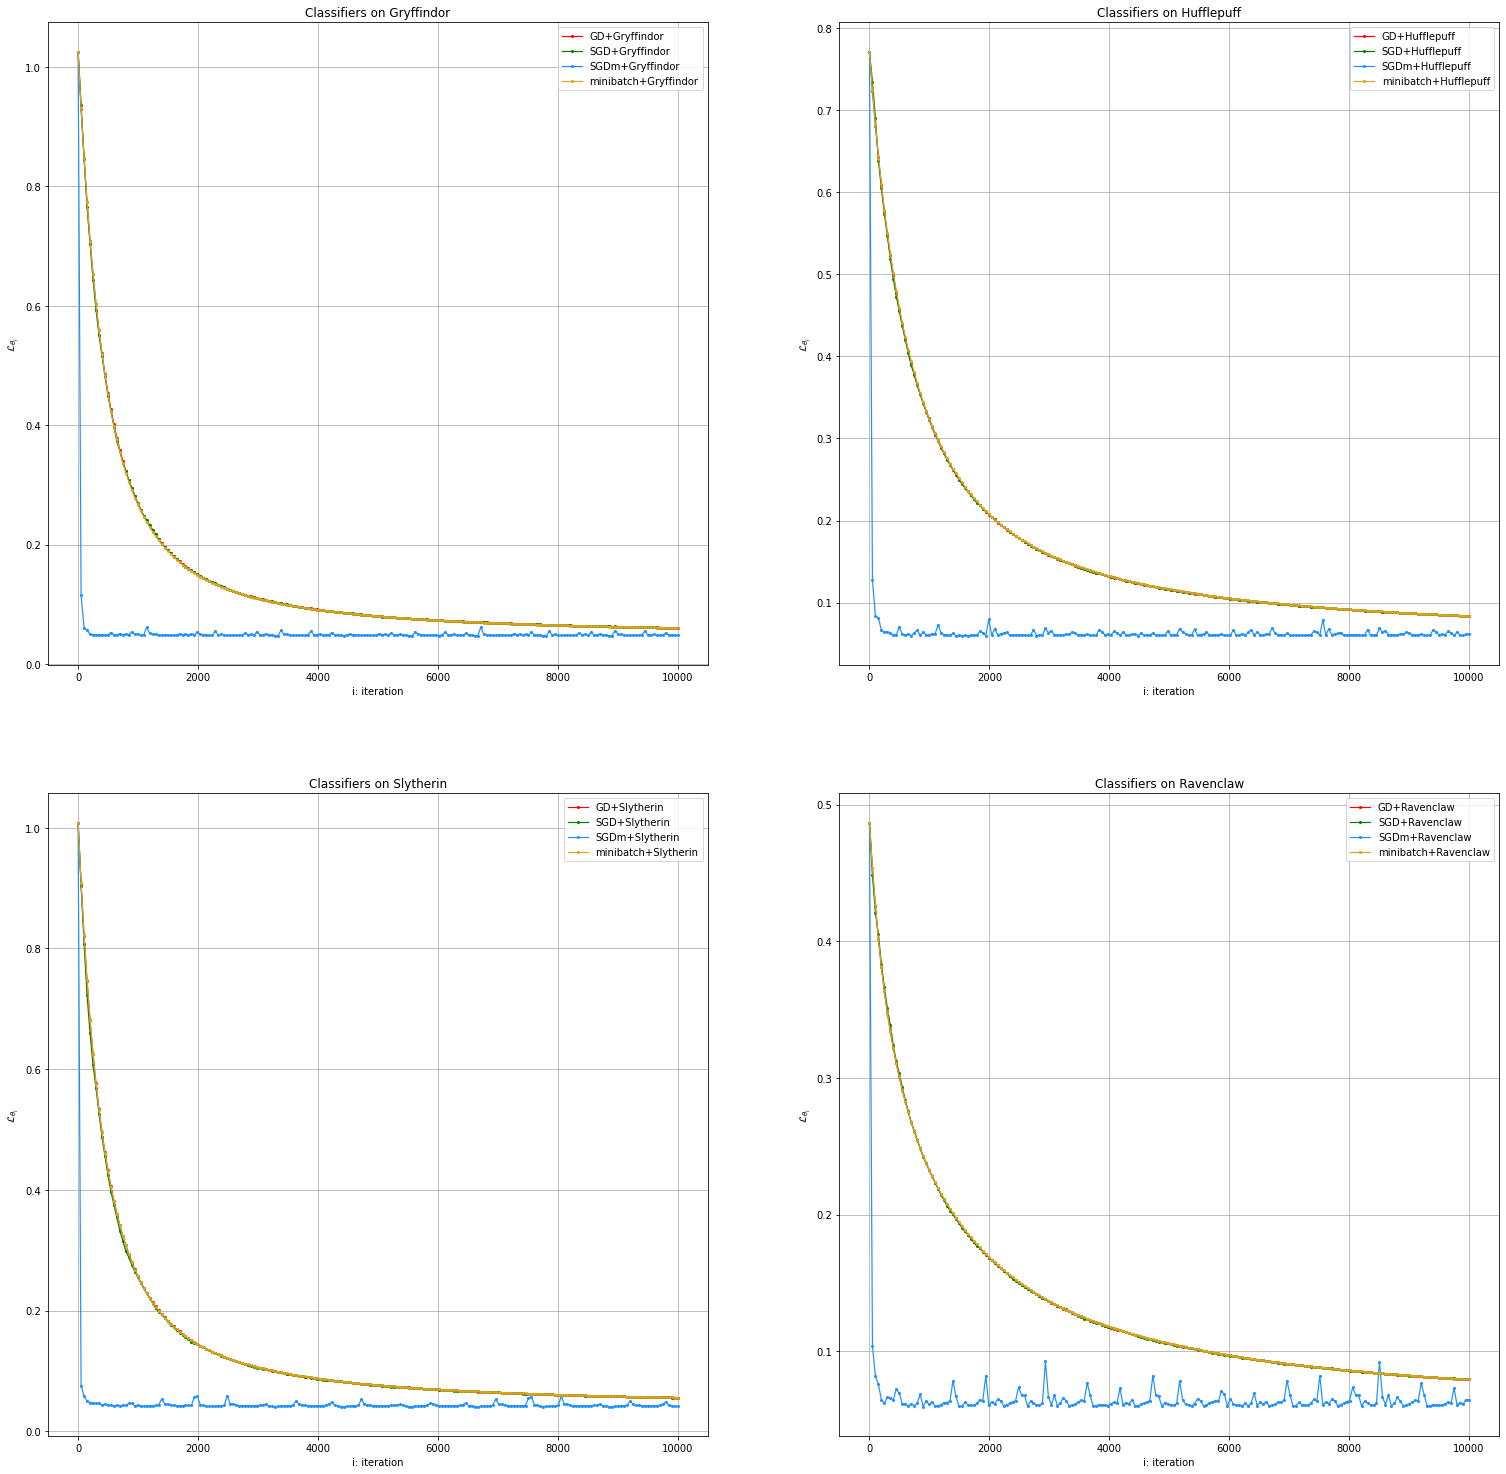

In [26]:
dct_palet = {"Hufflepuff":"dodgerblue", "Gryffindor":"red", "Slytherin":"green", "Ravenclaw":"goldenrod"}
dct_palet_gryffindor = {"GD+Gryffindor":"red",
                        "SGD+Gryffindor":"green",
                        "SGDm+Gryffindor":"dodgerblue",
                        "minibatch+Gryffindor":"goldenrod"}

dct_palet_slytherin = {"GD+Slytherin":"red",
                       "SGD+Slytherin":"green",
                       "SGDm+Slytherin":"dodgerblue",
                       "minibatch+Slytherin":"goldenrod"}

dct_palet_hufflepuff = {"GD+Hufflepuff":"red",
                        "SGD+Hufflepuff":"green",
                        "SGDm+Hufflepuff":"dodgerblue",
                        "minibatch+Hufflepuff":"goldenrod"}

dct_palet_ravenclaw = {"GD+Ravenclaw":"red",
                       "SGD+Ravenclaw":"green",
                       "SGDm+Ravenclaw":"dodgerblue",
                       "minibatch+Ravenclaw":"goldenrod"}

fig, axes = plt.subplots(2,2,figsize=(26,26))
#gs = GridSpec(4, 1, figure=fig)
#axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]

# --formatting the different axes -- #
axes[0][0].set_title("Classifiers on Gryffindor")
axes[0][0].set_xlabel("i: iteration")
axes[0][0].set_ylabel(r"$\mathcal{L}_{\theta_i}$")
#axes[0][0].set_yscale('log')
axes[0][0].grid()

axes[1][0].set_title("Classifiers on Slytherin")
axes[1][0].set_xlabel("i: iteration")
axes[1][0].set_ylabel(r"$\mathcal{L}_{\theta_i}$")
#axes[1][0].set_yscale('log')
axes[1][0].grid()

axes[0][1].set_title("Classifiers on Hufflepuff")
axes[0][1].set_xlabel("i: iteration")
axes[0][1].set_ylabel(r"$\mathcal{L}_{\theta_i}$")
#axes[0][1].set_yscale('log')
axes[0][1].grid()

axes[1][1].set_title("Classifiers on Ravenclaw")
axes[1][1].set_xlabel("i: iteration")
axes[1][1].set_ylabel(r"$\mathcal{L}_{\theta_i}$")
#axes[1][1].set_yscale('log')
axes[1][1].grid()

plot_cost_functions_models(clfs_gryffindor, x_train, y_train, axes[0][0], dct_palet_gryffindor, "Gryffindor")
plot_cost_functions_models(clfs_slytherin, x_train, y_train, axes[1][0], dct_palet_slytherin, "Slytherin")
plot_cost_functions_models(clfs_hufflepuff, x_train, y_train, axes[0][1], dct_palet_hufflepuff, "Ravenclaw")
plot_cost_functions_models(clfs_ravenclaw, x_train, y_train, axes[1][1], dct_palet_ravenclaw, "Hufflepuff")
axes[0][0].legend()
axes[1][0].legend()
axes[0][1].legend()
axes[1][1].legend()

# -- Displaying the plot -- #
plt.show()

### Observations:
* Nous constatons que la méthode **SGDm** minimise le plus rapidement la fonction de coût et cela pour les 4 classes.
* L'évolution de la fonction coût est très semblable pour les modèles utilisant les méthodes d'optimisation: **GD**, **SGD** et **minibatch**.
* Les valeurs des fonctions de coût des modèles basés sur **GD**, **SGD** et **minibatch** sont similaires à celle du modèle basé sur **SGDm** à partir de l'itération 8000 environ pour l'état paramétrique initial:
    * $\alpha = 1.10^{-2}$,
    * initialisation de $\theta$ et $b$ par ```np.random.randn```,
    * max_iter=10000,
    * $\lambda$=0.0 (pertinent que pour la descente de gradient stochastique avec inertie)

### (Apparté) Question possible: Pourquoi la descente de gradient stochastique ne présente pas une tendance décroissante '*bruitée*'

La raison vient de la standardisation des inputs.
Nous pouvons le mettre en évidence en comparant les évolutions des fonctions de coût pour des modèles utilisant la descente de gradient classique et stochastique pour des entrées standardisées et non standardisées.

In [27]:
# Le mode permet d'utiliser un modèle "basique" ou un modèle avec "historique"
if mode == "basic":
	model = mylogr
if mode == "history":
	model = mylogrwh

coef1 = np.random.rand(nb_features, 1)
coef2 = np.random.rand(nb_features, 1)
coef3 = np.random.rand(nb_features, 1)
coef4 = np.random.rand(nb_features, 1)
clf1_sgd_raw = model(coef1, alpha=1e-5, max_iter=5000, lambd=0.0, steps=100, tag="Gryffindor", method="SGD")
clf2_sgd_raw = model(coef2, alpha=1e-5, max_iter=5000, lambd=0.0, steps=100, tag="Slytherin", method="SGD")
clf3_sgd_raw = model(coef3, alpha=1e-5, max_iter=5000, lambd=0.0, steps=100, tag="Ravenclaw", method="SGD")
clf4_sgd_raw = model(coef4, alpha=1e-5, max_iter=5000, lambd=0.0, steps=100, tag="Hufflepuff", method="SGD")

clf1_gd_raw = model(coef1, alpha=1e-5, max_iter=5000, lambd=0.0, steps=100, tag="Gryffindor", method="GD")
clf2_gd_raw = model(coef2, alpha=1e-5, max_iter=5000, lambd=0.0, steps=100, tag="Slytherin", method="GD")
clf3_gd_raw = model(coef3, alpha=1e-5, max_iter=5000, lambd=0.0, steps=100, tag="Ravenclaw", method="GD")
clf4_gd_raw = model(coef4, alpha=1e-5, max_iter=5000, lambd=0.0, steps=100, tag="Hufflepuff", method="GD")


clfs_gd_raw = [clf1_gd_raw, clf2_gd_raw, clf3_gd_raw, clf4_gd_raw]
clfs_sgd_raw = [clf1_sgd_raw, clf2_sgd_raw, clf3_sgd_raw, clf4_sgd_raw]

In [28]:
i = 1
for clf in clfs_sgd_raw:
    clf.fit_history_(x_raw_train.values, y_train[f"target clf{i}"].values.reshape(-1,1))
    i += 1

In [29]:
i = 1
for clf in clfs_gd_raw:
    clf.fit_history_(x_raw_train.values, y_train[f"target clf{i}"].values.reshape(-1,1))
    i += 1

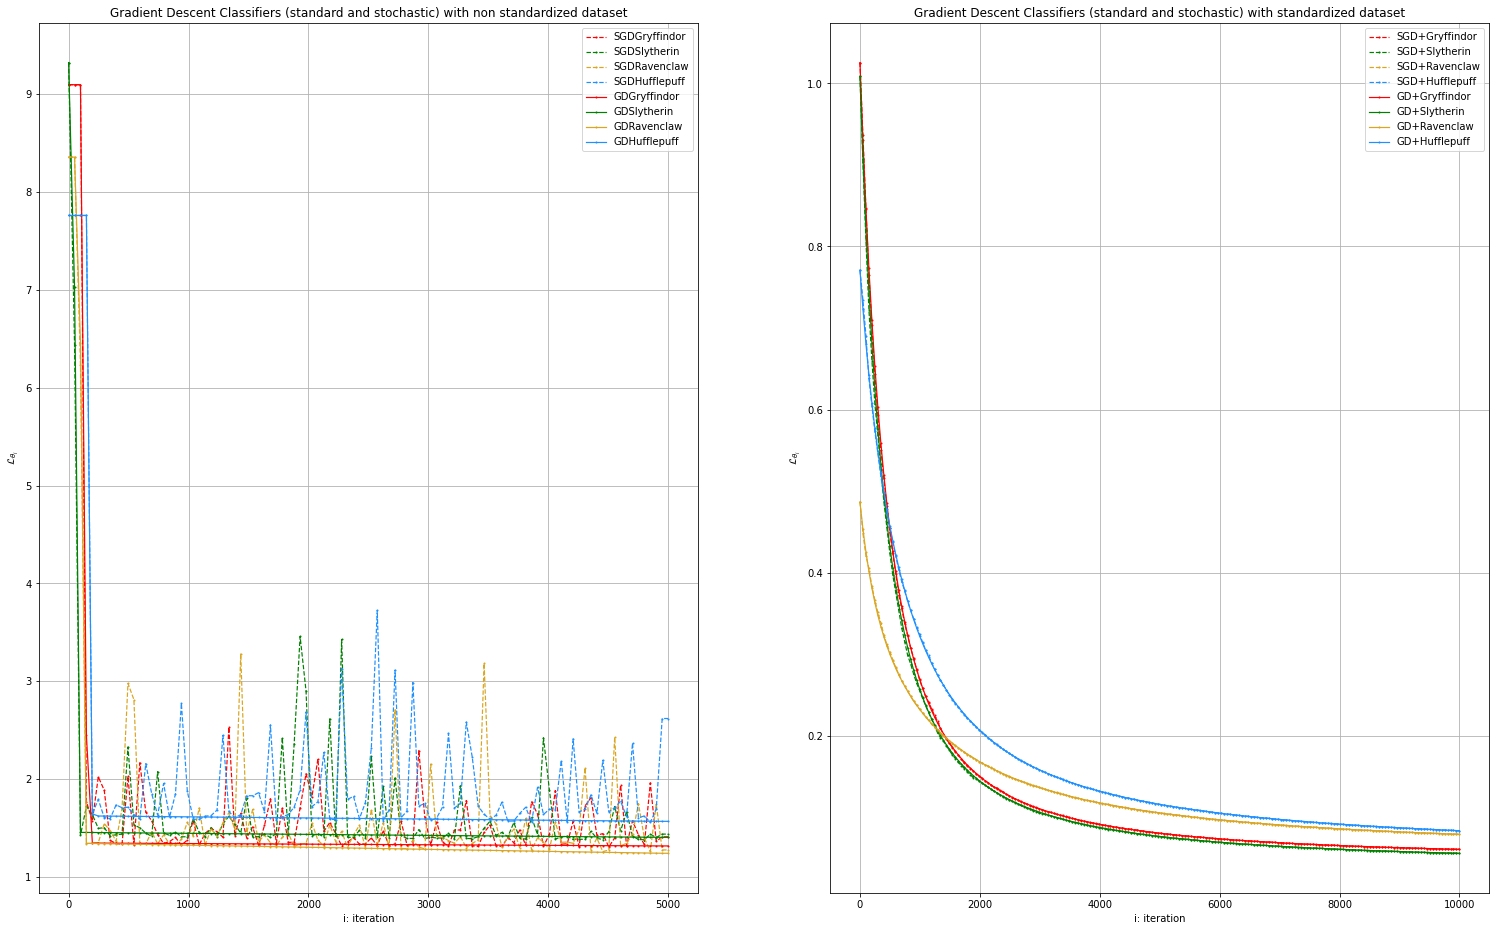

In [30]:
dct_palet = {"Hufflepuff":"dodgerblue", "Gryffindor":"red", "Slytherin":"green", "Ravenclaw":"goldenrod"}

fig, axes = plt.subplots(1,2,figsize=(26,16))
#gs = GridSpec(4, 1, figure=fig)
#axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]

# --formatting the different axes -- #
axes[0].set_title("Gradient Descent Classifiers (standard and stochastic) with non standardized dataset")
axes[0].set_xlabel("i: iteration")
axes[0].set_ylabel(r"$\mathcal{L}_{\theta_i}$")
#axes[0][0].set_yscale('log')
axes[0].grid()

axes[1].set_title("Gradient Descent Classifiers (standard and stochastic) with standardized dataset")
axes[1].set_xlabel("i: iteration")
axes[1].set_ylabel(r"$\mathcal{L}_{\theta_i}$")
axes[1].grid()

# -- plot for the fist axe (non standardized data)
for id_target, model in zip([1,2,3,4], clfs_sgd_raw):
    idx = np.linspace(start=0, stop=model.max_iter, num=model.steps + 2)
    cost = model.cost_history_(x_raw_train, y_train[f"target clf{id_target}"].values.reshape(-1,1))
    axes[0].plot(idx, cost.T, ls='--', marker='o', ms=1.0, lw=1.2, color=dct_palet[model.tag], label=model.method + model.tag)
    
for id_target, model in zip([1,2,3,4], clfs_gd_raw):
    idx = np.linspace(start=0, stop=model.max_iter, num=model.steps + 2)
    cost = model.cost_history_(x_raw_train, y_train[f"target clf{id_target}"].values.reshape(-1,1))
    axes[0].plot(idx, cost.T, ls='-', marker='o', ms=1.0, lw=1.2, color=dct_palet[model.tag], label=model.method + model.tag)

# -- plot for the fist axe (non standardized data)
for id_target, model in zip([1,2,3,4], clfs_sgd):
    idx = np.linspace(start=0, stop=model.max_iter, num=model.steps + 2)
    cost = model.cost_history_(x_train, y_train[f"target clf{id_target}"].values.reshape(-1,1))
    axes[1].plot(idx, cost.T, ls='--', marker='o', ms=1.0, lw=1.2, color=dct_palet[model.tag.split('+')[1]], label=model.tag)
    
for id_target, model in zip([1,2,3,4], clfs_gd):
    idx = np.linspace(start=0, stop=model.max_iter, num=model.steps + 2)
    cost = model.cost_history_(x_train, y_train[f"target clf{id_target}"].values.reshape(-1,1))
    axes[1].plot(idx, cost.T, ls='-', marker='o', ms=1.0, lw=1.2, color=dct_palet[model.tag.split('+')[1]], label= model.tag)
    
axes[0].legend()
axes[1].legend()

# -- Displaying the plot -- #
plt.show()

## Influence de la méthode d'optimisation sur les métriques d'évaluation (*precision*, *accuracy*, *recall*, *F1 score*):
Notons que les grandeurs d'évaluations sont calculées à partir du dataset de test (**y_dev**).

In [31]:
# -- Prediction of the target on the entire test set -- #
df_res = y_dev.copy()
df_res["pred clf1 GD"] = clf1_gd.predict_(x_dev.values)
df_res["pred clf2 GD"] = clf2_gd.predict_(x_dev.values)
df_res["pred clf3 GD"] = clf3_gd.predict_(x_dev.values)
df_res["pred clf4 GD"] = clf4_gd.predict_(x_dev.values)

df_res["pred clf1 SGD"] = clf1_sgd.predict_(x_dev.values)
df_res["pred clf2 SGD"] = clf2_sgd.predict_(x_dev.values)
df_res["pred clf3 SGD"] = clf3_sgd.predict_(x_dev.values)
df_res["pred clf4 SGD"] = clf4_sgd.predict_(x_dev.values)

df_res["pred clf1 SGDm"] = clf1_sgdm.predict_(x_dev.values)
df_res["pred clf2 SGDm"] = clf2_sgdm.predict_(x_dev.values)
df_res["pred clf3 SGDm"] = clf3_sgdm.predict_(x_dev.values)
df_res["pred clf4 SGDm"] = clf4_sgdm.predict_(x_dev.values)

df_res["pred clf1 minibatch"] = clf1_minibatch.predict_(x_dev.values)
df_res["pred clf2 minibatch"] = clf2_minibatch.predict_(x_dev.values)
df_res["pred clf3 minibatch"] = clf3_minibatch.predict_(x_dev.values)
df_res["pred clf4 minibatch"] = clf4_minibatch.predict_(x_dev.values)

In [32]:
df_res = df_res.reindex(columns=["Hogwarts House",
                                 "target clf1", "pred clf1 GD", "pred clf1 SGD", "pred clf1 SGDm", "pred clf1 minibatch",
                                 "target clf2", "pred clf2 GD", "pred clf2 SGD", "pred clf2 SGDm", "pred clf2 minibatch",
                                 "target clf3", "pred clf3 GD", "pred clf3 SGD", "pred clf3 SGDm", "pred clf3 minibatch",
                                 "target clf4", "pred clf4 GD", "pred clf4 SGD", "pred clf4 SGDm", "pred clf4 minibatch"])

In [33]:
df_res.head(5)

,Hogwarts House,target clf1,pred clf1 GD,pred clf1 SGD,pred clf1 SGDm,pred clf1 minibatch,target clf2,pred clf2 GD,pred clf2 SGD,pred clf2 SGDm,...,target clf3,pred clf3 GD,pred clf3 SGD,pred clf3 SGDm,pred clf3 minibatch,target clf4,pred clf4 GD,pred clf4 SGD,pred clf4 SGDm,pred clf4 minibatch
751,Ravenclaw,0,0.021307,0.021542,0.014066,0.021364,0,0.008097,0.008220,0.000651,...,1,0.965137,0.963636,0.986511,0.965127,0,0.062492,0.063118,0.010376,0.063609
1353,Ravenclaw,0,0.014601,0.014741,0.005187,0.014513,0,0.091379,0.092456,0.037605,...,1,0.961814,0.960234,0.988296,0.961793,0,0.008538,0.008612,0.000309,0.008704
185,Hufflepuff,0,0.035695,0.035944,0.004578,0.035835,0,0.017461,0.017810,0.009479,...,0,0.015762,0.015345,0.000320,0.015819,1,0.933775,0.934030,0.994894,0.932480
733,Hufflepuff,0,0.090945,0.091566,0.036242,0.091246,0,0.019259,0.019642,0.005047,...,0,0.031788,0.030997,0.001444,0.031836,1,0.710561,0.711628,0.885071,0.706427
186,Hufflepuff,0,0.008853,0.008925,0.001812,0.008835,0,0.016907,0.017376,0.003529,...,0,0.023052,0.022376,0.000421,0.023077,1,0.981082,0.981306,0.999448,0.980964


In [34]:
pred_GD_name = ["pred clf1 GD", "pred clf2 GD", "pred clf3 GD", "pred clf4 GD"]
pred_SGD_name = ["pred clf1 SGD", "pred clf2 SGD", "pred clf3 SGD", "pred clf4 SGD"]
pred_SGDm_name = ["pred clf1 SGDm", "pred clf2 SGDm", "pred clf3 SGDm", "pred clf4 SGDm"]
pred_minibatch_name = ["pred clf1 minibatch", "pred clf2 minibatch", "pred clf3 minibatch", "pred clf4 minibatch"]

dct_pred_GD = {"pred clf1 GD":"Gryffindor", "pred clf2 GD":"Slytherin", "pred clf3 GD":"Ravenclaw", "pred clf4 GD":"Hufflepuff"}
dct_pred_SGD = {"pred clf1 SGD":"Gryffindor", "pred clf2 SGD":"Slytherin", "pred clf3 SGD":"Ravenclaw", "pred clf4 SGD":"Hufflepuff"}
dct_pred_SGDm = {"pred clf1 SGDm":"Gryffindor", "pred clf2 SGDm":"Slytherin", "pred clf3 SGDm":"Ravenclaw", "pred clf4 SGDm":"Hufflepuff"}
dct_pred_minibatch = {"pred clf1 minibatch":"Gryffindor", "pred clf2 minibatch":"Slytherin", "pred clf3 minibatch":"Ravenclaw", "pred clf4 minibatch":"Hufflepuff"}
	
s_pred_label_GD = df_res[pred_GD_name].idxmax(axis="columns").replace(to_replace=dct_pred_GD)
s_pred_label_SGD = df_res[pred_SGD_name].idxmax(axis="columns").replace(to_replace=dct_pred_SGD)
s_pred_label_SGDm = df_res[pred_SGDm_name].idxmax(axis="columns").replace(to_replace=dct_pred_SGDm)
s_pred_label_minibatch = df_res[pred_minibatch_name].idxmax(axis="columns").replace(to_replace=dct_pred_minibatch)

df_res["predicted GD Hogwarts House"] = s_pred_label_GD
df_res["predicted SGD Hogwarts House"] = s_pred_label_SGD
df_res["predicted SGDm Hogwarts House"] = s_pred_label_SGDm
df_res["predicted minibatch Hogwarts House"] = s_pred_label_minibatch

In [35]:
df_res.head(3)

,Hogwarts House,target clf1,pred clf1 GD,pred clf1 SGD,pred clf1 SGDm,pred clf1 minibatch,target clf2,pred clf2 GD,pred clf2 SGD,pred clf2 SGDm,...,pred clf3 minibatch,target clf4,pred clf4 GD,pred clf4 SGD,pred clf4 SGDm,pred clf4 minibatch,predicted GD Hogwarts House,predicted SGD Hogwarts House,predicted SGDm Hogwarts House,predicted minibatch Hogwarts House
751,Ravenclaw,0,0.021307,0.021542,0.014066,0.021364,0,0.008097,0.008220,0.000651,...,0.965127,0,0.062492,0.063118,0.010376,0.063609,Ravenclaw,Ravenclaw,Ravenclaw,Ravenclaw
1353,Ravenclaw,0,0.014601,0.014741,0.005187,0.014513,0,0.091379,0.092456,0.037605,...,0.961793,0,0.008538,0.008612,0.000309,0.008704,Ravenclaw,Ravenclaw,Ravenclaw,Ravenclaw
185,Hufflepuff,0,0.035695,0.035944,0.004578,0.035835,0,0.017461,0.017810,0.009479,...,0.015819,1,0.933775,0.934030,0.994894,0.932480,Hufflepuff,Hufflepuff,Hufflepuff,Hufflepuff


In [36]:
def score_report(df:pd.DataFrame, metrics:list, name_pred="predicted Hogwarts House"):
	""" Prints a report on the score with the different metrics for all
	of the classifiers (predictions in the dataframe)
	
	Parameters:
		* df[pandas.DataFrame]: datafram containing the true label and the
								predicted labels of the different classifiers
		* metrics [list]: list of the different metrics to display in the
						  report for the different classifiers
	"""
	acceptable_metrics = ["accuracy", "precision", "recall", "specificity", "F1", "Confusion matrix"] 
	if not all([metric in acceptable_metrics for metric in metrics]):
		str_expt = "At least one element in the list metrics is incorrect or not handled."
		raise Exception(str_expt)

	index = ["Gryffindor", "Slytherin", "Ravenclaw", "Hufflepuff"]
	columns = metrics + ["size"]
	df_report = pd.DataFrame(data=np.zeros((len(index), len(columns))),
							 index=index, columns=columns)

	for house in index:
		for metric in metrics:
			if metric in ["accuracy", "precision", "recall", "F1"]:
				val = dct_metrics[metric](df["Hogwarts House"].values.reshape(-1,1),
										  df[name_pred].values.reshape(-1,1), house)
			df_report.loc[house, metric] = val
		df_report.loc[house, "size"] = df[df[name_pred] == house].shape[0]
	
	print("\nScore metrics report:\n", df_report)
	if "Confusion matrix" in metrics:
		print("\nConfusion matrix:\n",
			  mylogrmetrics.confusion_matrix_(df_res["Hogwarts House"].values.reshape(-1,1),
											  df_res[name_pred].values.reshape(-1,1)))

In [37]:
score_report(df_res, ["accuracy", "precision", "recall", "F1", "Confusion matrix"], name_pred="predicted GD Hogwarts House")


Score metrics report:
             accuracy  precision  recall      F1  Confusion matrix   size
Gryffindor    0.9917     0.9783  0.9783  0.9783            0.9783   92.0
Slytherin     0.9896     0.9770  0.9659  0.9714            0.9714   87.0
Ravenclaw     0.9833     0.9706  0.9706  0.9706            0.9706  136.0
Hufflepuff    0.9896     0.9818  0.9878  0.9848            0.9848  165.0

Confusion matrix:
             Gryffindor  Hufflepuff  Ravenclaw  Slytherin
Gryffindor        90.0         1.0        1.0        0.0
Hufflepuff         1.0       162.0        0.0        1.0
Ravenclaw          1.0         2.0      132.0        1.0
Slytherin          0.0         0.0        3.0       85.0


In [38]:
score_report(df_res, ["accuracy", "precision", "recall", "F1", "Confusion matrix"], name_pred="predicted SGD Hogwarts House")


Score metrics report:
             accuracy  precision  recall      F1  Confusion matrix   size
Gryffindor    0.9917     0.9783  0.9783  0.9783            0.9783   92.0
Slytherin     0.9896     0.9770  0.9659  0.9714            0.9714   87.0
Ravenclaw     0.9833     0.9706  0.9706  0.9706            0.9706  136.0
Hufflepuff    0.9896     0.9818  0.9878  0.9848            0.9848  165.0

Confusion matrix:
             Gryffindor  Hufflepuff  Ravenclaw  Slytherin
Gryffindor        90.0         1.0        1.0        0.0
Hufflepuff         1.0       162.0        0.0        1.0
Ravenclaw          1.0         2.0      132.0        1.0
Slytherin          0.0         0.0        3.0       85.0


In [39]:
score_report(df_res, ["accuracy", "precision", "recall", "F1", "Confusion matrix"], name_pred="predicted SGDm Hogwarts House")


Score metrics report:
             accuracy  precision  recall      F1  Confusion matrix   size
Gryffindor    0.9917     0.9783  0.9783  0.9783            0.9783   92.0
Slytherin     0.9896     0.9770  0.9659  0.9714            0.9714   87.0
Ravenclaw     0.9833     0.9706  0.9706  0.9706            0.9706  136.0
Hufflepuff    0.9896     0.9818  0.9878  0.9848            0.9848  165.0

Confusion matrix:
             Gryffindor  Hufflepuff  Ravenclaw  Slytherin
Gryffindor        90.0         1.0        1.0        0.0
Hufflepuff         1.0       162.0        0.0        1.0
Ravenclaw          1.0         2.0      132.0        1.0
Slytherin          0.0         0.0        3.0       85.0


In [40]:
score_report(df_res, ["accuracy", "precision", "recall", "F1", "Confusion matrix"], name_pred="predicted minibatch Hogwarts House")


Score metrics report:
             accuracy  precision  recall      F1  Confusion matrix   size
Gryffindor    0.9917     0.9783  0.9783  0.9783            0.9783   92.0
Slytherin     0.9896     0.9770  0.9659  0.9714            0.9714   87.0
Ravenclaw     0.9833     0.9706  0.9706  0.9706            0.9706  136.0
Hufflepuff    0.9896     0.9818  0.9878  0.9848            0.9848  165.0

Confusion matrix:
             Gryffindor  Hufflepuff  Ravenclaw  Slytherin
Gryffindor        90.0         1.0        1.0        0.0
Hufflepuff         1.0       162.0        0.0        1.0
Ravenclaw          1.0         2.0      132.0        1.0
Slytherin          0.0         0.0        3.0       85.0


### Observations:
les performances des modèles *One-vs-All* (4 classifieurs binaires, un pour chacune des classes/maisons, avec la même méthode d'optimisation) utilisant une méthode d'optimisation différente (**GD**, **SGD**, **SGDm**, **minibatch**) ont été calculé juste au dessus.

Nous pouvons observer que les performances en fin d'entraînement sont identiques peu importe la méthode d'optimisation utilisée.
Les erreurs de prédictions pour un One-vs-All donné (c'est-à-dire pour une méthode d'optimisation donnée) sont compris entre 1 et 5 exemples sur le dataset de test (**[x/y]_dev**).

**À l'issue de l'entraînement**, nous ne sommes pas en mesure d'apprécier l'effet de la méthode d'optimisation sur les performances.

Nous allons donc observer l'évolution des performances au cours de l'entraînement pour conclure sur l'intérêt, dans ce cas présent, d'une méthode d'optimisation vis-à-vis des autres disponibles.

In [41]:
# Possible value for metric: [accuracy_score_, precision_score_, recall_score_, specificity_score_]
# Concerning target: "Gryffindor" is 1, "Slytherin" is 2, "Hufflepuff" is 3 and "Ravenclaw" is 4
def plot_metric(models, x, y, target, axe, metric_, palet):
    for model in models:
        y_ = y[f"target clf{target}"].values.reshape(-1,1)
        idx = np.linspace(start=0, stop=model.max_iter, num=model.steps + 2)
        pred = np.round(model.predict_history_(x)).astype(int)
        history = [metric_(y_, pred[:,jj].reshape(-1,1)) for jj in range(pred.shape[1])]
        axe.plot(idx, history, ls='-', marker='o', ms=2, lw=1.2, color=palet[model.tag], label=model.tag)

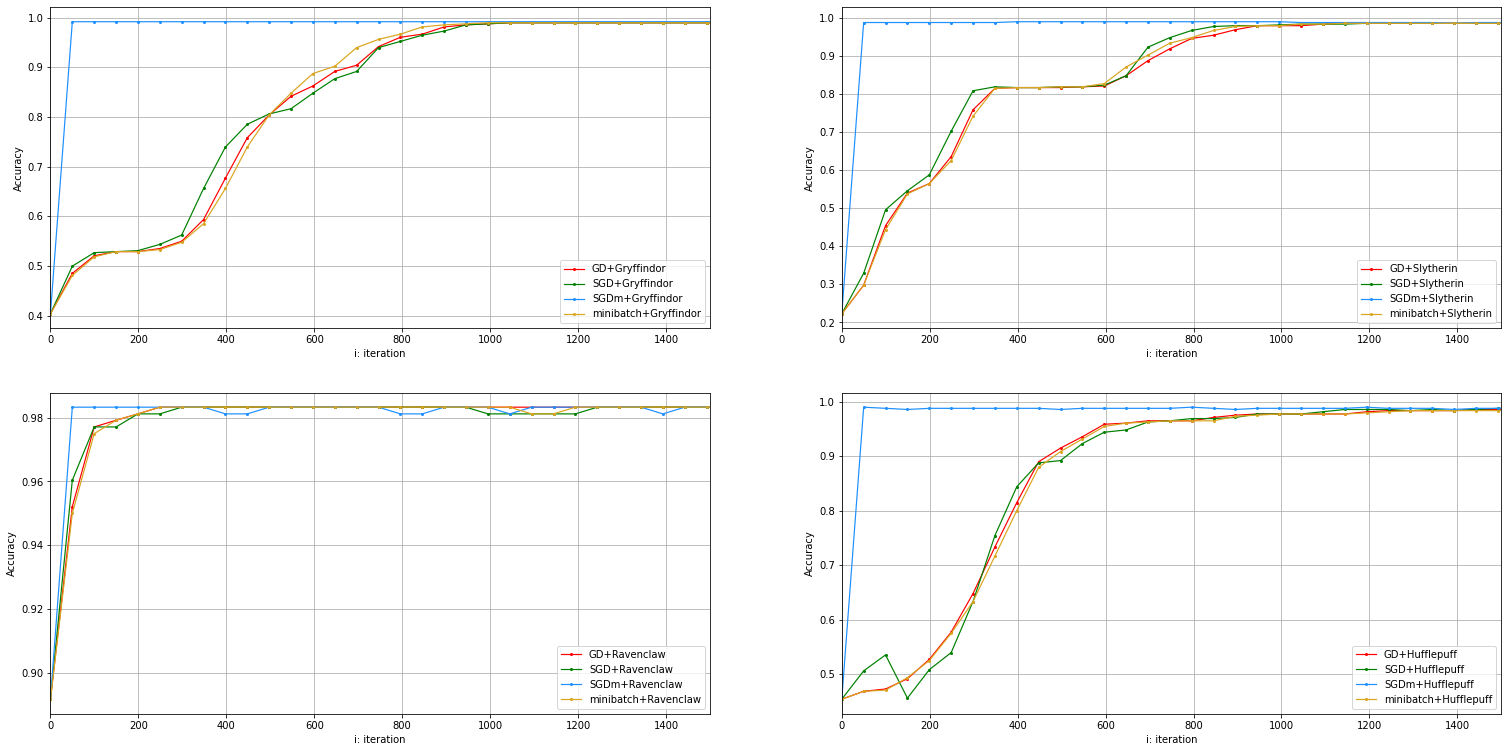

In [42]:
fig, axes = plt.subplots(2,2,figsize=(26,13))

# --formatting the different axes -- #
axes[0][0].set_xlabel("i: iteration")
axes[0][0].set_ylabel("Accuracy")
axes[0][0].grid()

axes[1][0].set_xlabel("i: iteration")
axes[1][0].set_ylabel("Accuracy")
axes[1][0].grid()

axes[0][1].set_xlabel("i: iteration")
axes[0][1].set_ylabel("Accuracy")
axes[0][1].grid()

axes[1][1].set_xlabel("i: iteration")
axes[1][1].set_ylabel("Accuracy")
axes[1][1].grid()

plot_metric([clf1_gd, clf1_sgd, clf1_sgdm, clf1_minibatch], x_dev, y_dev, 1, axes[0][0], mylogrmetrics.accuracy_score_, dct_palet_gryffindor)
plot_metric([clf2_gd, clf2_sgd, clf2_sgdm, clf2_minibatch], x_dev, y_dev, 2, axes[0][1], mylogrmetrics.accuracy_score_, dct_palet_slytherin)
plot_metric([clf3_gd, clf3_sgd, clf3_sgdm, clf3_minibatch], x_dev, y_dev, 3, axes[1][0], mylogrmetrics.accuracy_score_, dct_palet_ravenclaw)
plot_metric([clf4_gd, clf4_sgd, clf4_sgdm, clf4_minibatch], x_dev, y_dev, 4, axes[1][1], mylogrmetrics.accuracy_score_, dct_palet_hufflepuff)

axes[0][0].legend()
axes[1][0].legend()
axes[0][1].legend()
axes[1][1].legend()

axes[0][0].set_xlim(0, 1500)
axes[1][0].set_xlim(0, 1500)
axes[0][1].set_xlim(0, 1500)
axes[1][1].set_xlim(0, 1500)

plt.show()

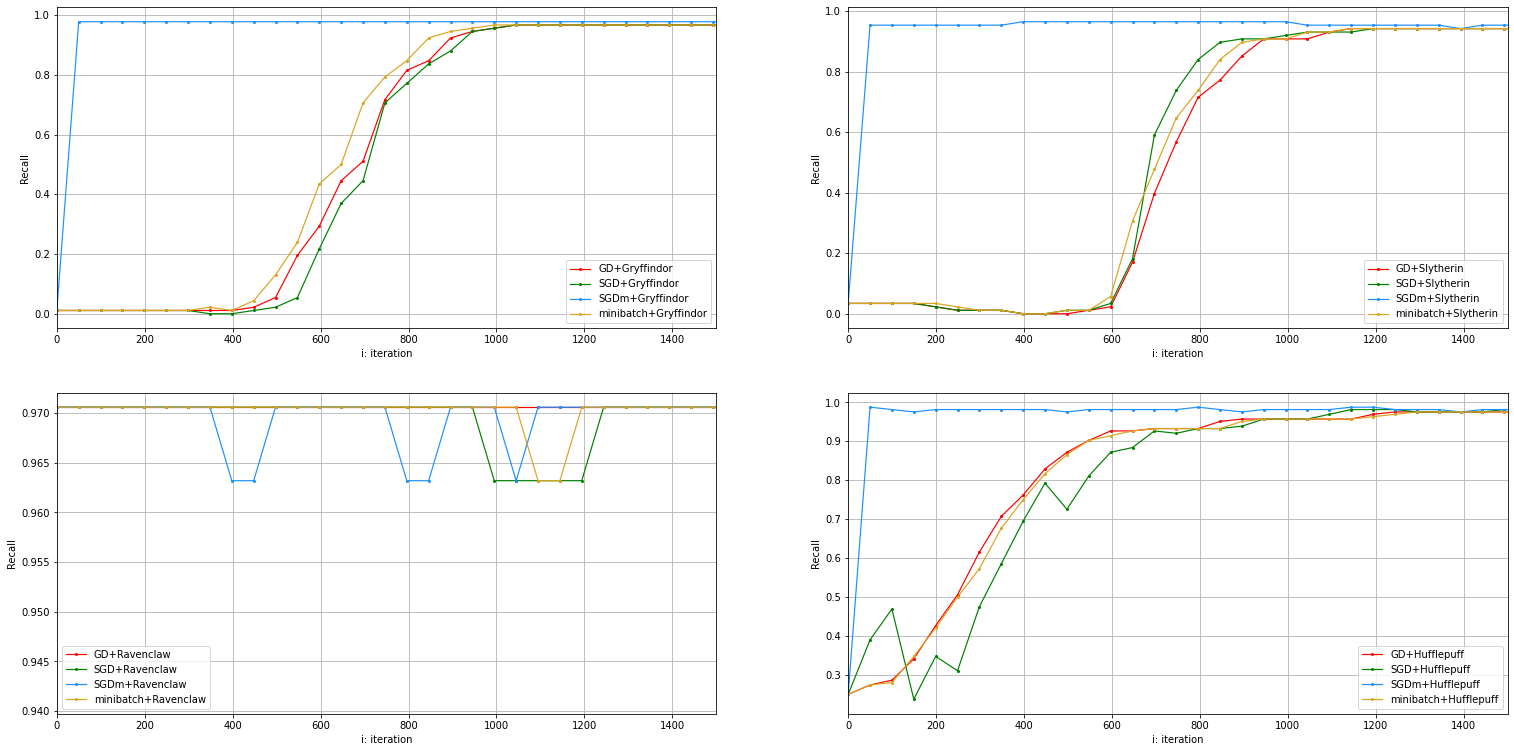

In [43]:
fig, axes = plt.subplots(2,2,figsize=(26,13))

# --formatting the different axes -- #
axes[0][0].set_xlabel("i: iteration")
axes[0][0].set_ylabel("Recall")
axes[0][0].grid()

axes[1][0].set_xlabel("i: iteration")
axes[1][0].set_ylabel("Recall")
axes[1][0].grid()

axes[0][1].set_xlabel("i: iteration")
axes[0][1].set_ylabel("Recall")
axes[0][1].grid()

axes[1][1].set_xlabel("i: iteration")
axes[1][1].set_ylabel("Recall")
axes[1][1].grid()

plot_metric([clf1_gd, clf1_sgd, clf1_sgdm, clf1_minibatch], x_dev, y_dev, 1, axes[0][0], mylogrmetrics.recall_score_, dct_palet_gryffindor)
plot_metric([clf2_gd, clf2_sgd, clf2_sgdm, clf2_minibatch], x_dev, y_dev, 2, axes[0][1], mylogrmetrics.recall_score_, dct_palet_slytherin)
plot_metric([clf3_gd, clf3_sgd, clf3_sgdm, clf3_minibatch], x_dev, y_dev, 3, axes[1][0], mylogrmetrics.recall_score_, dct_palet_ravenclaw)
plot_metric([clf4_gd, clf4_sgd, clf4_sgdm, clf4_minibatch], x_dev, y_dev, 4, axes[1][1], mylogrmetrics.recall_score_, dct_palet_hufflepuff)

axes[0][0].legend()
axes[1][0].legend()
axes[0][1].legend()
axes[1][1].legend()

axes[0][0].set_xlim(0, 1500)
axes[1][0].set_xlim(0, 1500)
axes[0][1].set_xlim(0, 1500)
axes[1][1].set_xlim(0, 1500)

plt.show()

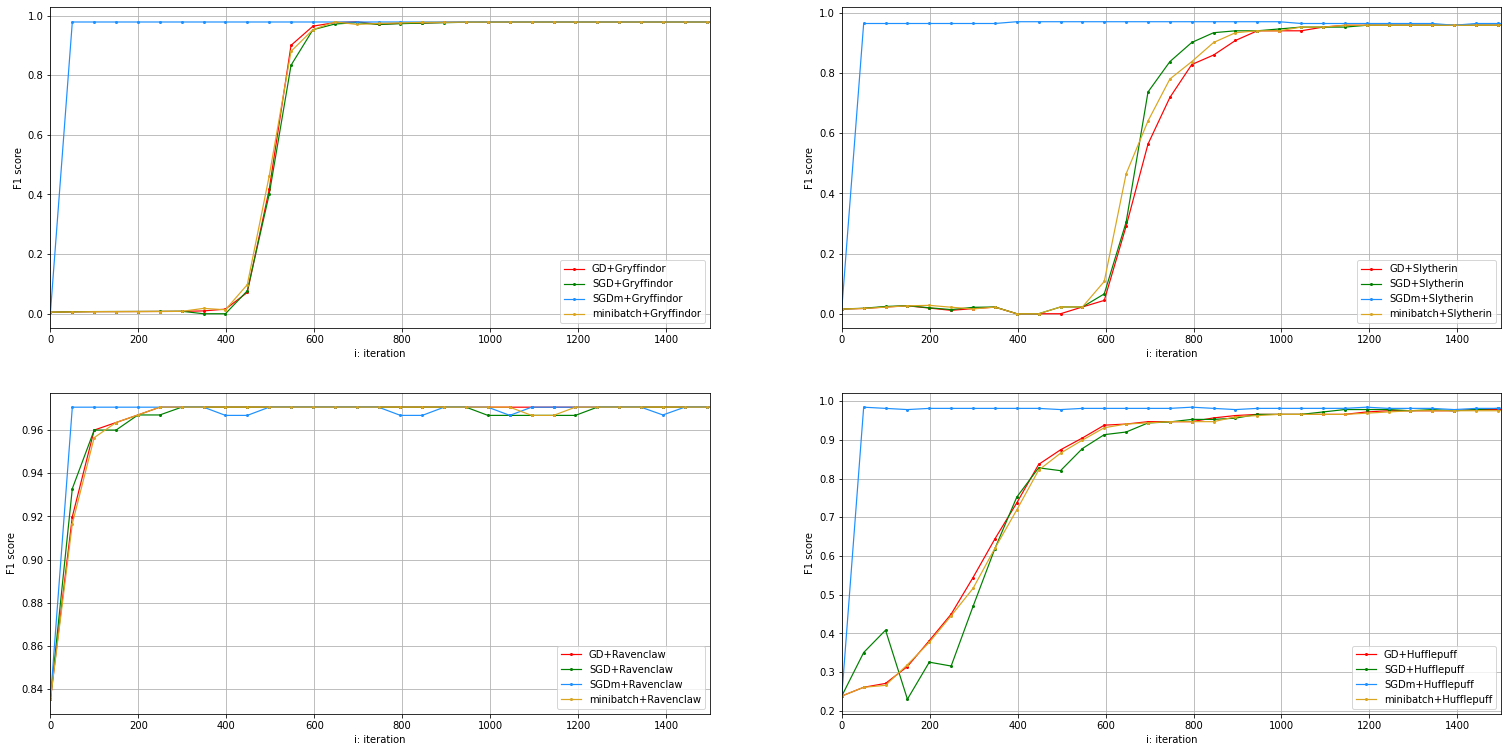

In [44]:
fig, axes = plt.subplots(2,2,figsize=(26,13))

# --formatting the different axes -- #
axes[0][0].set_xlabel("i: iteration")
axes[0][0].set_ylabel("F1 score")
axes[0][0].grid()

axes[1][0].set_xlabel("i: iteration")
axes[1][0].set_ylabel("F1 score")
axes[1][0].grid()

axes[0][1].set_xlabel("i: iteration")
axes[0][1].set_ylabel("F1 score")
axes[0][1].grid()

axes[1][1].set_xlabel("i: iteration")
axes[1][1].set_ylabel("F1 score")
axes[1][1].grid()

plot_metric([clf1_gd, clf1_sgd, clf1_sgdm, clf1_minibatch], x_dev, y_dev, 1, axes[0][0], mylogrmetrics.precision_score_, dct_palet_gryffindor)
plot_metric([clf2_gd, clf2_sgd, clf2_sgdm, clf2_minibatch], x_dev, y_dev, 2, axes[0][1], mylogrmetrics.f1_score_, dct_palet_slytherin)
plot_metric([clf3_gd, clf3_sgd, clf3_sgdm, clf3_minibatch], x_dev, y_dev, 3, axes[1][0], mylogrmetrics.f1_score_, dct_palet_ravenclaw)
plot_metric([clf4_gd, clf4_sgd, clf4_sgdm, clf4_minibatch], x_dev, y_dev, 4, axes[1][1], mylogrmetrics.f1_score_, dct_palet_hufflepuff)

axes[0][0].legend()
axes[1][0].legend()
axes[0][1].legend()
axes[1][1].legend()

axes[0][0].set_xlim(0, 1500)
axes[1][0].set_xlim(0, 1500)
axes[0][1].set_xlim(0, 1500)
axes[1][1].set_xlim(0, 1500)

plt.show()

Sur les figures montrant l'évolution des performances (*accuracy*, *recall*, *F1-score*) en cours d'entraînement, nous pouvons constater:
* Que les classifieurs avec la méthode d'optimisation **SGDm** atteignent des valeurs de performances optimales (aux environs ou avant la $50^{ieme}$ itérations)
* En moyenne (avec toutes les courbes: *accuracy*, *recall* et *F1-score* et de manière visuelle) les classifieurs avec la méthode d'optimisation *GD*, *SGD* et *minibatch* atteignent des performance optimales aux alentours de 700 itérations.

## Conclusion:
Pour ce dataset et après standardisation, la méthode d'optimisation *descente de gradient stochastique avec inertie* procure un avantage vis-à-vis des autres méthodes d'optimisation en permettant d'atteindre des performances optimales plus rapidement que les autres méthodes.

# Influence du taux d'apprentissage sur les performance des modèles:
## Modèle avec optimisation *"Gradient Descent"*:

In [45]:
mode = "history"
# Le mode permet d'utiliser un modèle "basique" ou un modèle avec "historique"
if mode == "basic":
	model = mylogr
if mode == "history":
	model = mylogrwh

coef1 = np.random.rand(nb_features, 1)
clf1a_gd = model(coef1, alpha=1e-1, max_iter=10000, lambd=0.0, steps=200, tag="Gryffindor", method="GD")
clf1b_gd = model(coef1, alpha=1e-1, max_iter=10000, lambd=0.0, steps=200, tag="Gryffindor", method="GD")
clf1c_gd = model(coef1, alpha=1e-2, max_iter=10000, lambd=0.0, steps=200, tag="Gryffindor", method="GD")
clf1d_gd = model(coef1, alpha=1e-3, max_iter=10000, lambd=0.0, steps=200, tag="Gryffindor", method="GD")
clf1e_gd = model(coef1, alpha=1e-4, max_iter=10000, lambd=0.0, steps=200, tag="Gryffindor", method="GD")

clf1a_gd.alpha = 1000

In [46]:
clfs_gd_alpha = [clf1a_gd, clf1b_gd, clf1c_gd, clf1d_gd, clf1e_gd]

In [47]:
# ==== ==
# Fitting process for all logistic classifiers
# ==== ==
i = 1
# --- For "GD"
for clf in clfs_gd_alpha:
    clf.fit_history_(x_train.values, y_train[f"target clf1"].values.reshape(-1,1))
    i += 1

/home/user42/Documents/dslr_vgsph/my_logistic_regression.py:63: RuntimeWarning: overflow encountered in exp
  pred = np.divide (1.0, 1.0 + np.exp(-z))


/home/user42/Documents/dslr_vgsph/my_logistic_regression.py:244: RuntimeWarning: overflow encountered in exp
  pred = np.divide(1.0, 1.0 + np.exp(-z))


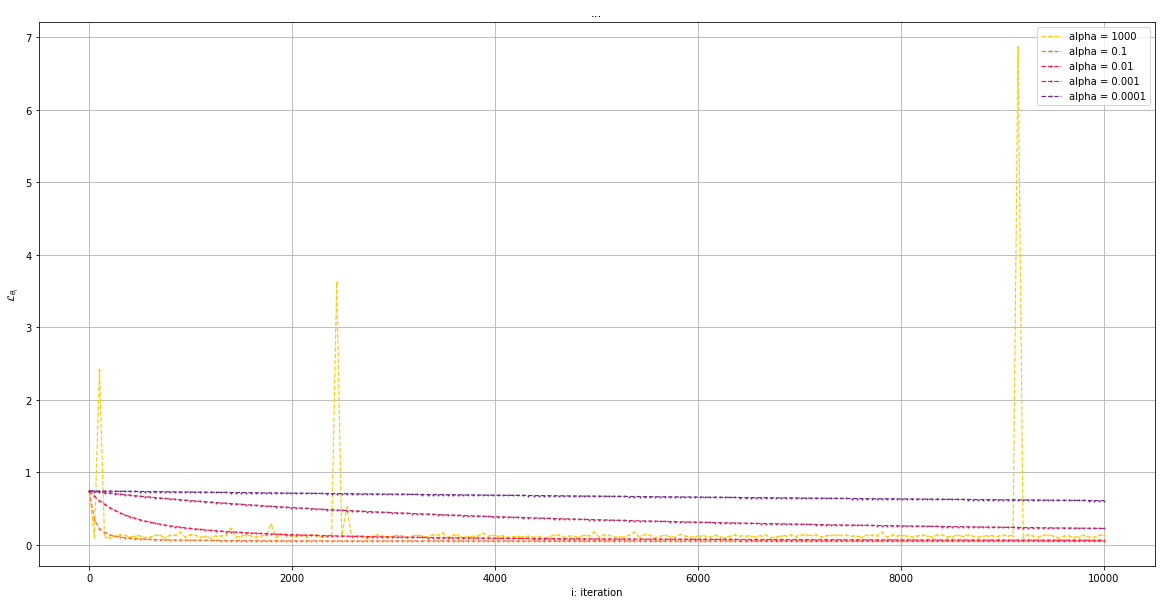

In [48]:
fig, axes = plt.subplots(1,1,figsize=(20,10))
#gs = GridSpec(4, 1, figure=fig)
#axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]

# --formatting the different axes -- #
axes.set_title("...")
axes.set_xlabel("i: iteration")
axes.set_ylabel(r"$\mathcal{L}_{\theta_i}$")
axes.grid()

# -- plot for the fist axe (non standardized data)
for model, color in zip(clfs_gd_alpha, ["#FFCC0D", "#FF7326", "#FF194D", "#BF2669", "#702A8C"]):
    idx = np.linspace(start=0, stop=model.max_iter, num=model.steps + 2)
    cost = model.cost_history_(x_train, y_train[f"target clf1"].values.reshape(-1,1))
    axes.plot(idx, cost.T, ls='--', marker='o', ms=1.0, lw=1.2, color=color, label="alpha = " + str(model.alpha))

axes.legend()

# -- Displaying the plot -- #
plt.show()

## Observations:
* Le taux d'apprentissage $\alpha$ influence la vitesse à laquelle la convergence est atteinte.
* Plus le taux d'apprentissage est élevé plus la convergence est rapide, mais cela n'est vrai que jusqu'à une valeur, au delà, la mise à jour des valeurs coefficient a trop d'influence entraînant une divergence.

## Modèle avec optimisation *"Stochastic Gradient Descent"* et "Stochastic Gradient Descent with Momentum":

In [49]:
mode = "history"
# Le mode permet d'utiliser un modèle "basique" ou un modèle avec "historique"
if mode == "basic":
	model = mylogr
if mode == "history":
	model = mylogrwh

#-- stochastic gradient descent model
coef1a = np.random.rand(nb_features, 1)
clf1a_sgd = model(coef1a, alpha=1e-1, max_iter=10000, lambd=0.0, steps=200, tag="Gryffindor", method="GD")
clf1b_sgd = model(coef1a, alpha=1e-1, max_iter=10000, lambd=0.0, steps=200, tag="Gryffindor", method="GD")
clf1c_sgd = model(coef1a, alpha=1e-2, max_iter=10000, lambd=0.0, steps=200, tag="Gryffindor", method="GD")
clf1d_sgd = model(coef1a, alpha=1e-3, max_iter=10000, lambd=0.0, steps=200, tag="Gryffindor", method="GD")
clf1e_sgd = model(coef1a, alpha=1e-4, max_iter=10000, lambd=0.0, steps=200, tag="Gryffindor", method="GD")

clf1a_sgd.alpha = 1000
clfs_sgd_alpha = [clf1a_sgd, clf1b_sgd, clf1c_sgd, clf1d_sgd, clf1e_sgd]

#-- stochastic gradient descent with momentum model
coef1b = np.random.rand(nb_features, 1)
clf1a_sgdm = model(coef1, alpha=1e-1, max_iter=10000, lambd=0.0, steps=200, tag="Gryffindor", method="GD")
clf1b_sgdm = model(coef1, alpha=1e-1, max_iter=10000, lambd=0.0, steps=200, tag="Gryffindor", method="GD")
clf1c_sgdm = model(coef1, alpha=1e-2, max_iter=10000, lambd=0.0, steps=200, tag="Gryffindor", method="GD")
clf1d_sgdm = model(coef1, alpha=1e-3, max_iter=10000, lambd=0.0, steps=200, tag="Gryffindor", method="GD")
clf1e_sgdm = model(coef1, alpha=1e-4, max_iter=10000, lambd=0.0, steps=200, tag="Gryffindor", method="GD")


clf1a_sgdm.alpha = 1000

clfs_sgdm_alpha = [clf1a_sgdm, clf1b_sgdm, clf1c_sgdm, clf1d_sgdm, clf1e_sgdm]

In [50]:
# ==== ==
# Fitting process for all logistic classifiers
# ==== ==
i = 1
# --- For "SGD"
for clf in clfs_sgd_alpha:
    clf.fit_history_(x_train.values, y_train[f"target clf1"].values.reshape(-1,1))
    print(f"fin de l'entrainement du modele {i}")
    i += 1

# ==== ==
# Fitting process for all logistic classifiers
# ==== ==
i = 1
# --- For "SGDm"
for clf in clfs_sgdm_alpha:
    clf.fit_history_(x_train.values, y_train[f"target clf1"].values.reshape(-1,1))
    print(f"fin de l'entrainement du modele {i}")
    i += 1

/home/user42/Documents/dslr_vgsph/my_logistic_regression.py:63: RuntimeWarning: overflow encountered in exp
  pred = np.divide (1.0, 1.0 + np.exp(-z))


fin de l'entrainement du modele 1
fin de l'entrainement du modele 2
fin de l'entrainement du modele 3
fin de l'entrainement du modele 4
fin de l'entrainement du modele 5
fin de l'entrainement du modele 1
fin de l'entrainement du modele 2
fin de l'entrainement du modele 3
fin de l'entrainement du modele 4
fin de l'entrainement du modele 5


/home/user42/Documents/dslr_vgsph/my_logistic_regression.py:244: RuntimeWarning: overflow encountered in exp
  pred = np.divide(1.0, 1.0 + np.exp(-z))
/home/user42/Documents/dslr_vgsph/my_logistic_regression.py:244: RuntimeWarning: overflow encountered in exp
  pred = np.divide(1.0, 1.0 + np.exp(-z))


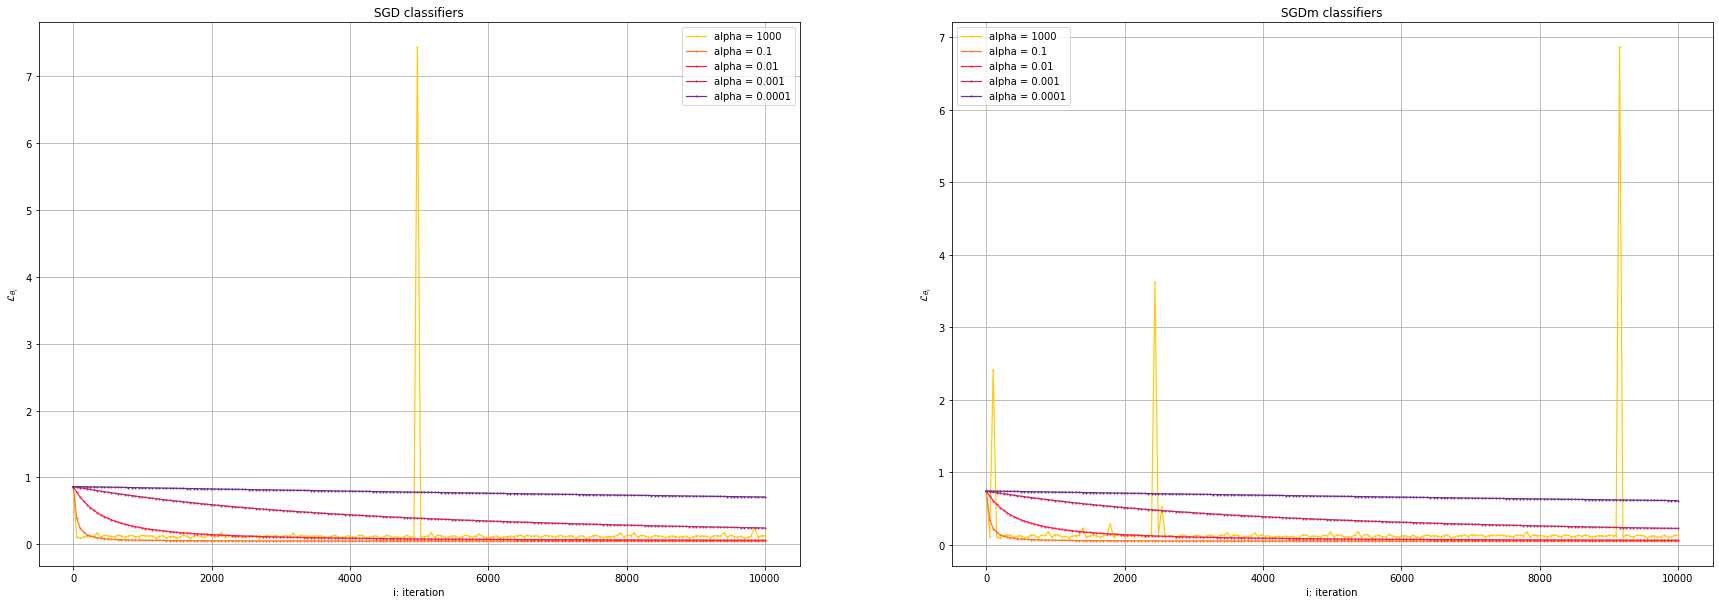

In [51]:
fig, axes = plt.subplots(1,2,figsize=(30,10))
#gs = GridSpec(4, 1, figure=fig)
#axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]

# --formatting the different axes -- #
axes[0].set_title("SGD classifiers")
axes[0].set_xlabel("i: iteration")
axes[0].set_ylabel(r"$\mathcal{L}_{\theta_i}$")
axes[0].grid()
axes[1].set_title("SGDm classifiers")
axes[1].set_xlabel("i: iteration")
axes[1].set_ylabel(r"$\mathcal{L}_{\theta_i}$")
axes[1].grid()

for model, color in zip(clfs_sgd_alpha, ["#FFCC0D", "#FF7326", "#FF194D", "#BF2669", "#702A8C"]):
    idx = np.linspace(start=0, stop=model.max_iter, num=model.steps + 2)
    cost = model.cost_history_(x_train, y_train[f"target clf1"].values.reshape(-1,1))
    axes[0].plot(idx, cost.T, ls='-', marker='o', ms=1.0, lw=1.2, color=color, label="alpha = " + str(model.alpha))
    
for model, color in zip(clfs_sgdm_alpha, ["#FFCC0D", "#FF7326", "#FF194D", "#BF2669", "#702A8C"]):
    idx = np.linspace(start=0, stop=model.max_iter, num=model.steps + 2)
    cost = model.cost_history_(x_train, y_train[f"target clf1"].values.reshape(-1,1))
    axes[1].plot(idx, cost.T, ls='-', marker='o', ms=1.0, lw=1.2, color=color, label="alpha = " + str(model.alpha))

axes[0].legend()
axes[1].legend()

# -- Displaying the plot -- #
plt.show()

## Observations:
* Les même observation peuvent être faite que pour les classifieurs utilisant la méthode d'optimisation de la descente de gradient.

# Influence du coefficient de régularisation sur les performance des modèles:

In [52]:
mode = "history"
# Le mode permet d'utiliser un modèle "basique" ou un modèle avec "historique"
if mode == "basic":
	model = mylogr
if mode == "history":
	model = mylogrwh

coef1 = np.random.rand(nb_features, 1)
clf1_lmbd_a_gd = model(coef1, alpha=1e-1, max_iter=10000, lambd=0.0, steps=200, tag="Gryffindor", method="GD")
clf1_lmbd_b_gd = model(coef1, alpha=1e-1, max_iter=10000, lambd=0.01, steps=200, tag="Gryffindor", method="GD")
clf1_lmbd_c_gd = model(coef1, alpha=1e-1, max_iter=10000, lambd=0.05, steps=200, tag="Gryffindor", method="GD")
clf1_lmbd_d_gd = model(coef1, alpha=1e-1, max_iter=10000, lambd=0.1, steps=200, tag="Gryffindor", method="GD")
clf1_lmbd_e_gd = model(coef1, alpha=1e-1, max_iter=10000, lambd=0.5, steps=200, tag="Gryffindor", method="GD")

coef2 = np.random.rand(nb_features, 1)
clf2_lmbd_a_gd = model(coef2, alpha=1e-1, max_iter=10000, lambd=0.0, steps=200, tag="Slytherin", method="GD")
clf2_lmbd_b_gd = model(coef2, alpha=1e-1, max_iter=10000, lambd=0.01, steps=200, tag="Slytherin", method="GD")
clf2_lmbd_c_gd = model(coef2, alpha=1e-1, max_iter=10000, lambd=0.05, steps=200, tag="Slytherin", method="GD")
clf2_lmbd_d_gd = model(coef2, alpha=1e-1, max_iter=10000, lambd=0.1, steps=200, tag="Slytherin", method="GD")
clf2_lmbd_e_gd = model(coef2, alpha=1e-1, max_iter=10000, lambd=0.5, steps=200, tag="Slytherin", method="GD")

coef3 = np.random.rand(nb_features, 1)
clf3_lmbd_a_gd = model(coef3, alpha=1e-1, max_iter=10000, lambd=0.0, steps=200, tag="Hufflepuff", method="GD")
clf3_lmbd_b_gd = model(coef3, alpha=1e-1, max_iter=10000, lambd=0.01, steps=200, tag="Hufflepuff", method="GD")
clf3_lmbd_c_gd = model(coef3, alpha=1e-1, max_iter=10000, lambd=0.05, steps=200, tag="Hufflepuff", method="GD")
clf3_lmbd_d_gd = model(coef3, alpha=1e-1, max_iter=10000, lambd=0.1, steps=200, tag="Hufflepuff", method="GD")
clf3_lmbd_e_gd = model(coef3, alpha=1e-1, max_iter=10000, lambd=0.5, steps=200, tag="Hufflepuff", method="GD")

coef4 = np.random.rand(nb_features, 1)
clf4_lmbd_a_gd = model(coef4, alpha=1e-1, max_iter=10000, lambd=0.0, steps=200, tag="Ravenclaw", method="GD")
clf4_lmbd_b_gd = model(coef4, alpha=1e-1, max_iter=10000, lambd=0.01, steps=200, tag="Ravenclaw", method="GD")
clf4_lmbd_c_gd = model(coef4, alpha=1e-1, max_iter=10000, lambd=0.05, steps=200, tag="Ravenclaw", method="GD")
clf4_lmbd_d_gd = model(coef4, alpha=1e-1, max_iter=10000, lambd=0.1, steps=200, tag="Ravenclaw", method="GD")
clf4_lmbd_e_gd = model(coef4, alpha=1e-1, max_iter=10000, lambd=0.5, steps=200, tag="Ravenclaw", method="GD")

clfs_gd_lambd_gry = [clf1_lmbd_a_gd, clf1_lmbd_b_gd, clf1_lmbd_c_gd, clf1_lmbd_d_gd, clf1_lmbd_e_gd]
clfs_gd_lambd_sly = [clf2_lmbd_a_gd, clf2_lmbd_b_gd, clf2_lmbd_c_gd, clf2_lmbd_d_gd, clf2_lmbd_e_gd]
clfs_gd_lambd_huff = [clf3_lmbd_a_gd, clf3_lmbd_b_gd, clf3_lmbd_c_gd, clf3_lmbd_d_gd, clf3_lmbd_e_gd]
clfs_gd_lambd_rav = [clf4_lmbd_a_gd, clf4_lmbd_b_gd, clf4_lmbd_c_gd, clf4_lmbd_d_gd, clf4_lmbd_e_gd]

In [53]:
# ==== ==
# Fitting process for all logistic classifiers
# ==== ==
i = 1
# --- For "GD" for Gryffindor
for clf in clfs_gd_lambd_gry:
    clf.fit_history_(x_train.values, y_train[f"target clf1"].values.reshape(-1,1))
    print(f"[Gryffindor] fin de l'entrainement du modele {i}")
    i += 1
    
i = 1
# --- For "GD" for Slytherin
for clf in clfs_gd_lambd_sly:
    clf.fit_history_(x_train.values, y_train[f"target clf2"].values.reshape(-1,1))
    print(f"[Slytherin] fin de l'entrainement du modele {i}")
    i += 1
    
i = 1
# --- For "GD" for Hufflepuff
for clf in clfs_gd_lambd_huff:
    clf.fit_history_(x_train.values, y_train[f"target clf3"].values.reshape(-1,1))
    print(f"[Hufflepuff] fin de l'entrainement du modele {i}")
    i += 1
    
i = 1
# --- For "GD" for Ravenclaw
for clf in clfs_gd_lambd_rav:
    clf.fit_history_(x_train.values, y_train[f"target clf4"].values.reshape(-1,1))
    print(f"[Ravenclaw] fin de l'entrainement du modele {i}")
    i += 1

[Gryffindor] fin de l'entrainement du modele 1
[Gryffindor] fin de l'entrainement du modele 2
[Gryffindor] fin de l'entrainement du modele 3
[Gryffindor] fin de l'entrainement du modele 4
[Gryffindor] fin de l'entrainement du modele 5
[Slytherin] fin de l'entrainement du modele 1
[Slytherin] fin de l'entrainement du modele 2
[Slytherin] fin de l'entrainement du modele 3
[Slytherin] fin de l'entrainement du modele 4
[Slytherin] fin de l'entrainement du modele 5
[Hufflepuff] fin de l'entrainement du modele 1
[Hufflepuff] fin de l'entrainement du modele 2
[Hufflepuff] fin de l'entrainement du modele 3
[Hufflepuff] fin de l'entrainement du modele 4
[Hufflepuff] fin de l'entrainement du modele 5
[Ravenclaw] fin de l'entrainement du modele 1
[Ravenclaw] fin de l'entrainement du modele 2
[Ravenclaw] fin de l'entrainement du modele 3
[Ravenclaw] fin de l'entrainement du modele 4
[Ravenclaw] fin de l'entrainement du modele 5


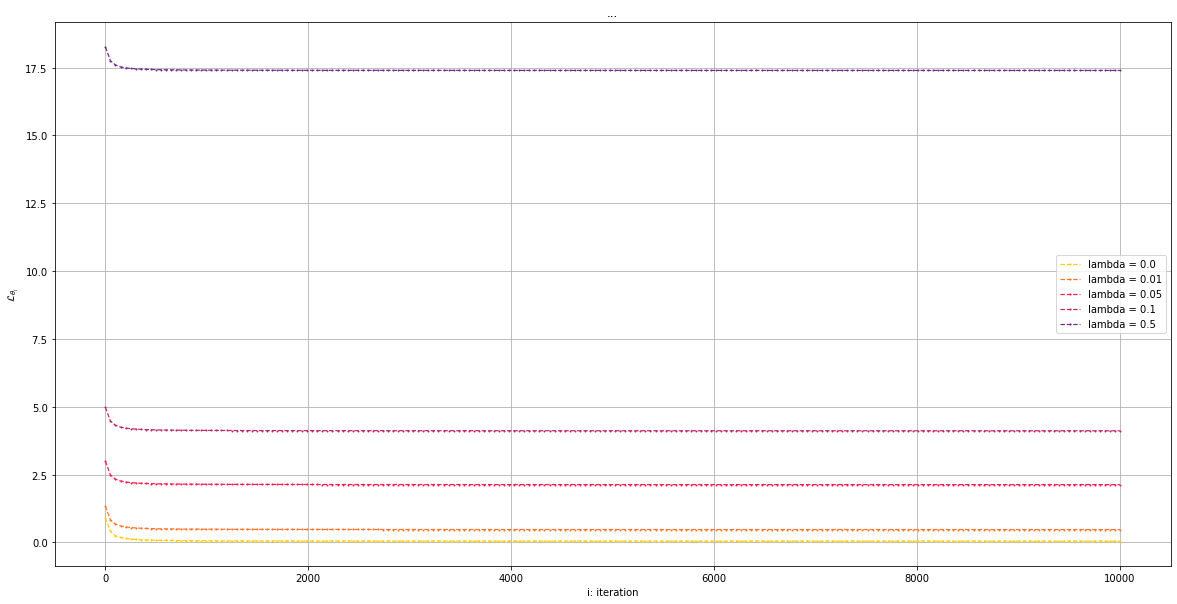

In [54]:
fig, axes = plt.subplots(1,1,figsize=(20,10))
#gs = GridSpec(4, 1, figure=fig)
#axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]

# --formatting the different axes -- #
axes.set_title("...")
axes.set_xlabel("i: iteration")
axes.set_ylabel(r"$\mathcal{L}_{\theta_i}$")
axes.grid()

# -- plot for the fist axe (non standardized data)
for model, color in zip(clfs_gd_lambd_gry, ["#FFCC0D", "#FF7326", "#FF194D", "#BF2669", "#702A8C"]):
    idx = np.linspace(start=0, stop=model.max_iter, num=model.steps + 2)
    cost = model.cost_history_(x_train, y_train[f"target clf1"].values.reshape(-1,1))
    axes.plot(idx, cost.T, ls='--', marker='o', ms=1.0, lw=1.2, color=color, label="lambda = " + str(model.lambd))

axes.legend()

# -- Displaying the plot -- #
plt.show()

In [55]:
# -- Prediction of the target on the entire test set -- #
df_res2 = y_dev.copy()
df_res2["pred clf1 GD 1"] = clf1_lmbd_a_gd.predict_(x_dev.values)
df_res2["pred clf1 GD 2"] = clf1_lmbd_b_gd.predict_(x_dev.values)
df_res2["pred clf1 GD 3"] = clf1_lmbd_c_gd.predict_(x_dev.values)
df_res2["pred clf1 GD 4"] = clf1_lmbd_d_gd.predict_(x_dev.values)
df_res2["pred clf1 GD 5"] = clf1_lmbd_e_gd.predict_(x_dev.values)

df_res2["pred clf2 GD 1"] = clf2_lmbd_a_gd.predict_(x_dev.values)
df_res2["pred clf2 GD 2"] = clf2_lmbd_b_gd.predict_(x_dev.values)
df_res2["pred clf2 GD 3"] = clf2_lmbd_c_gd.predict_(x_dev.values)
df_res2["pred clf2 GD 4"] = clf2_lmbd_d_gd.predict_(x_dev.values)
df_res2["pred clf2 GD 5"] = clf2_lmbd_e_gd.predict_(x_dev.values)

df_res2["pred clf3 GD 1"] = clf3_lmbd_a_gd.predict_(x_dev.values)
df_res2["pred clf3 GD 2"] = clf3_lmbd_b_gd.predict_(x_dev.values)
df_res2["pred clf3 GD 3"] = clf3_lmbd_c_gd.predict_(x_dev.values)
df_res2["pred clf3 GD 4"] = clf3_lmbd_d_gd.predict_(x_dev.values)
df_res2["pred clf3 GD 5"] = clf3_lmbd_e_gd.predict_(x_dev.values)

df_res2["pred clf4 GD 1"] = clf4_lmbd_a_gd.predict_(x_dev.values)
df_res2["pred clf4 GD 2"] = clf4_lmbd_b_gd.predict_(x_dev.values)
df_res2["pred clf4 GD 3"] = clf4_lmbd_c_gd.predict_(x_dev.values)
df_res2["pred clf4 GD 4"] = clf4_lmbd_d_gd.predict_(x_dev.values)
df_res2["pred clf4 GD 5"] = clf4_lmbd_e_gd.predict_(x_dev.values)

In [56]:
df_res2 = df_res2.reindex(columns=["Hogwarts House",
                                   "target clf1", "pred clf1 GD 1", "pred clf1 GD 2", "pred clf1 GD 3", "pred clf1 GD 4", "pred clf1 GD 5",
                                   "target clf2", "pred clf2 GD 1", "pred clf2 GD 2", "pred clf2 GD 3", "pred clf2 GD 4", "pred clf2 GD 5",
                                   "target clf3", "pred clf3 GD 1", "pred clf3 GD 2", "pred clf3 GD 3", "pred clf3 GD 4", "pred clf3 GD 5",
                                   "target clf4", "pred clf4 GD 1", "pred clf4 GD 2", "pred clf4 GD 3", "pred clf4 GD 4", "pred clf4 GD 5"])

In [57]:
df_res2.head(5)

,Hogwarts House,target clf1,pred clf1 GD 1,pred clf1 GD 2,pred clf1 GD 3,pred clf1 GD 4,pred clf1 GD 5,target clf2,pred clf2 GD 1,pred clf2 GD 2,...,pred clf3 GD 2,pred clf3 GD 3,pred clf3 GD 4,pred clf3 GD 5,target clf4,pred clf4 GD 1,pred clf4 GD 2,pred clf4 GD 3,pred clf4 GD 4,pred clf4 GD 5
751,Ravenclaw,0,0.006778,0.006816,0.006966,0.007151,0.008535,0,0.000873,0.000885,...,0.993095,0.992731,0.992270,0.988453,0,0.009166,0.009301,0.009843,0.010531,0.016215
1353,Ravenclaw,0,0.003047,0.003073,0.003178,0.003309,0.004340,0,0.036352,0.036489,...,0.993233,0.992848,0.992359,0.988260,0,0.000409,0.000419,0.000459,0.000512,0.001031
185,Hufflepuff,0,0.007606,0.007675,0.007953,0.008302,0.011115,0,0.004627,0.004666,...,0.001676,0.001788,0.001931,0.003188,1,0.988692,0.988538,0.987916,0.987128,0.980602
733,Hufflepuff,0,0.040717,0.040879,0.041526,0.042329,0.048408,0,0.004473,0.004513,...,0.005102,0.005377,0.005726,0.008615,1,0.827222,0.826497,0.823642,0.820176,0.796044
186,Hufflepuff,0,0.001871,0.001892,0.001973,0.002076,0.002894,0,0.004857,0.004891,...,0.002413,0.002576,0.002786,0.004624,1,0.998073,0.998038,0.997893,0.997707,0.996034


In [58]:
pred_GD1_name = ["pred clf1 GD 1", "pred clf2 GD 1", "pred clf3 GD 1", "pred clf4 GD 1"]
pred_GD2_name = ["pred clf1 GD 2", "pred clf2 GD 2", "pred clf3 GD 2", "pred clf4 GD 2"]
pred_GD3_name = ["pred clf1 GD 3", "pred clf2 GD 3", "pred clf3 GD 3", "pred clf4 GD 3"]
pred_GD4_name = ["pred clf1 GD 4", "pred clf2 GD 4", "pred clf3 GD 4", "pred clf4 GD 4"]
pred_GD5_name = ["pred clf1 GD 5", "pred clf2 GD 5", "pred clf3 GD 5", "pred clf4 GD 5"]

dct_pred_GD1 = {"pred clf1 GD 1":"Gryffindor", "pred clf2 GD 1":"Slytherin", "pred clf3 GD 1":"Ravenclaw", "pred clf4 GD 1":"Hufflepuff"}
dct_pred_GD2 = {"pred clf1 GD 2":"Gryffindor", "pred clf2 GD 2":"Slytherin", "pred clf3 GD 2":"Ravenclaw", "pred clf4 GD 2":"Hufflepuff"}
dct_pred_GD3 = {"pred clf1 GD 3":"Gryffindor", "pred clf2 GD 3":"Slytherin", "pred clf3 GD 3":"Ravenclaw", "pred clf4 GD 3":"Hufflepuff"}
dct_pred_GD4 = {"pred clf1 GD 4":"Gryffindor", "pred clf2 GD 4":"Slytherin", "pred clf3 GD 4":"Ravenclaw", "pred clf4 GD 4":"Hufflepuff"}
dct_pred_GD5 = {"pred clf1 GD 5":"Gryffindor", "pred clf2 GD 5":"Slytherin", "pred clf3 GD 5":"Ravenclaw", "pred clf4 GD 5":"Hufflepuff"}
	
s_pred_label_GD1 = df_res2[pred_GD1_name].idxmax(axis="columns").replace(to_replace=dct_pred_GD1)
s_pred_label_GD2 = df_res2[pred_GD2_name].idxmax(axis="columns").replace(to_replace=dct_pred_GD2)
s_pred_label_GD3 = df_res2[pred_GD3_name].idxmax(axis="columns").replace(to_replace=dct_pred_GD3)
s_pred_label_GD4 = df_res2[pred_GD4_name].idxmax(axis="columns").replace(to_replace=dct_pred_GD4)
s_pred_label_GD5 = df_res2[pred_GD5_name].idxmax(axis="columns").replace(to_replace=dct_pred_GD5)

df_res2["predicted GD 1 Hogwarts House"] = s_pred_label_GD1
df_res2["predicted GD 2 Hogwarts House"] = s_pred_label_GD2
df_res2["predicted GD 3 Hogwarts House"] = s_pred_label_GD3
df_res2["predicted GD 4 Hogwarts House"] = s_pred_label_GD4
df_res2["predicted GD 5 Hogwarts House"] = s_pred_label_GD5

In [59]:
df_res2.head(3)

,Hogwarts House,target clf1,pred clf1 GD 1,pred clf1 GD 2,pred clf1 GD 3,pred clf1 GD 4,pred clf1 GD 5,target clf2,pred clf2 GD 1,pred clf2 GD 2,...,pred clf4 GD 1,pred clf4 GD 2,pred clf4 GD 3,pred clf4 GD 4,pred clf4 GD 5,predicted GD 1 Hogwarts House,predicted GD 2 Hogwarts House,predicted GD 3 Hogwarts House,predicted GD 4 Hogwarts House,predicted GD 5 Hogwarts House
751,Ravenclaw,0,0.006778,0.006816,0.006966,0.007151,0.008535,0,0.000873,0.000885,...,0.009166,0.009301,0.009843,0.010531,0.016215,Ravenclaw,Ravenclaw,Ravenclaw,Ravenclaw,Ravenclaw
1353,Ravenclaw,0,0.003047,0.003073,0.003178,0.003309,0.004340,0,0.036352,0.036489,...,0.000409,0.000419,0.000459,0.000512,0.001031,Ravenclaw,Ravenclaw,Ravenclaw,Ravenclaw,Ravenclaw
185,Hufflepuff,0,0.007606,0.007675,0.007953,0.008302,0.011115,0,0.004627,0.004666,...,0.988692,0.988538,0.987916,0.987128,0.980602,Hufflepuff,Hufflepuff,Hufflepuff,Hufflepuff,Hufflepuff


In [60]:
df_res2.columns

Index(['Hogwarts House', 'target clf1', 'pred clf1 GD 1', 'pred clf1 GD 2',
       'pred clf1 GD 3', 'pred clf1 GD 4', 'pred clf1 GD 5', 'target clf2',
       'pred clf2 GD 1', 'pred clf2 GD 2', 'pred clf2 GD 3', 'pred clf2 GD 4',
       'pred clf2 GD 5', 'target clf3', 'pred clf3 GD 1', 'pred clf3 GD 2',
       'pred clf3 GD 3', 'pred clf3 GD 4', 'pred clf3 GD 5', 'target clf4',
       'pred clf4 GD 1', 'pred clf4 GD 2', 'pred clf4 GD 3', 'pred clf4 GD 4',
       'pred clf4 GD 5', 'predicted GD 1 Hogwarts House',
       'predicted GD 2 Hogwarts House', 'predicted GD 3 Hogwarts House',
       'predicted GD 4 Hogwarts House', 'predicted GD 5 Hogwarts House'],
      dtype='object')

In [61]:
#["accuracy", "precision", "recall", "F1", "Confusion matrix"]
score_report(df_res2, ["accuracy", "precision", "recall", "F1"], name_pred="predicted GD 1 Hogwarts House")


Score metrics report:
             accuracy  precision  recall      F1   size
Gryffindor    0.9917     0.9783  0.9783  0.9783   92.0
Slytherin     0.9896     0.9770  0.9659  0.9714   87.0
Ravenclaw     0.9833     0.9706  0.9706  0.9706  136.0
Hufflepuff    0.9896     0.9818  0.9878  0.9848  165.0


In [62]:
score_report(df_res2, ["accuracy", "precision", "recall", "F1"], name_pred="predicted GD 2 Hogwarts House")


Score metrics report:
             accuracy  precision  recall      F1   size
Gryffindor    0.9917     0.9783  0.9783  0.9783   92.0
Slytherin     0.9896     0.9770  0.9659  0.9714   87.0
Ravenclaw     0.9833     0.9706  0.9706  0.9706  136.0
Hufflepuff    0.9896     0.9818  0.9878  0.9848  165.0


In [63]:
score_report(df_res2, ["accuracy", "precision", "recall", "F1"], name_pred="predicted GD 3 Hogwarts House")


Score metrics report:
             accuracy  precision  recall      F1   size
Gryffindor    0.9917     0.9783  0.9783  0.9783   92.0
Slytherin     0.9896     0.9770  0.9659  0.9714   87.0
Ravenclaw     0.9833     0.9706  0.9706  0.9706  136.0
Hufflepuff    0.9896     0.9818  0.9878  0.9848  165.0


In [64]:
score_report(df_res2, ["accuracy", "precision", "recall", "F1"], name_pred="predicted GD 4 Hogwarts House")


Score metrics report:
             accuracy  precision  recall      F1   size
Gryffindor    0.9917     0.9783  0.9783  0.9783   92.0
Slytherin     0.9896     0.9770  0.9659  0.9714   87.0
Ravenclaw     0.9833     0.9706  0.9706  0.9706  136.0
Hufflepuff    0.9896     0.9818  0.9878  0.9848  165.0


In [65]:
score_report(df_res2, ["accuracy", "precision", "recall", "F1"], name_pred="predicted GD 5 Hogwarts House")


Score metrics report:
             accuracy  precision  recall      F1   size
Gryffindor    0.9917     0.9783  0.9783  0.9783   92.0
Slytherin     0.9896     0.9770  0.9659  0.9714   87.0
Ravenclaw     0.9833     0.9706  0.9706  0.9706  136.0
Hufflepuff    0.9896     0.9818  0.9878  0.9848  165.0


In [66]:
clf1_lmbd_f_gd = mylogrwh(coef1, alpha=1e-1, max_iter=10000, lambd=50, steps=200, tag="Gryffindor", method="GD")
clf2_lmbd_f_gd = mylogrwh(coef2, alpha=1e-1, max_iter=10000, lambd=50, steps=200, tag="Gryffindor", method="GD")
clf3_lmbd_f_gd = mylogrwh(coef3, alpha=1e-1, max_iter=10000, lambd=50, steps=200, tag="Gryffindor", method="GD")
clf4_lmbd_f_gd = mylogrwh(coef4, alpha=1e-1, max_iter=10000, lambd=50, steps=200, tag="Gryffindor", method="GD")

In [67]:
clf1_lmbd_f_gd.fit_history_(x_train.values, y_train[f"target clf1"].values.reshape(-1,1))
clf2_lmbd_f_gd.fit_history_(x_train.values, y_train[f"target clf2"].values.reshape(-1,1))
clf3_lmbd_f_gd.fit_history_(x_train.values, y_train[f"target clf3"].values.reshape(-1,1))
clf4_lmbd_f_gd.fit_history_(x_train.values, y_train[f"target clf4"].values.reshape(-1,1))

(array([[-1.31983055],
        [ 0.94826744],
        [ 0.5615474 ],
        [-1.35258998],
        [ 0.57731626]]),
 array([-0.9449045]))

In [68]:
df_res2["pred clf1 GD 6"] = clf1_lmbd_f_gd.predict_(x_dev.values)
df_res2["pred clf2 GD 6"] = clf2_lmbd_f_gd.predict_(x_dev.values)
df_res2["pred clf3 GD 6"] = clf3_lmbd_f_gd.predict_(x_dev.values)
df_res2["pred clf4 GD 6"] = clf4_lmbd_f_gd.predict_(x_dev.values)

In [69]:
pred_GD6_name = ["pred clf1 GD 6", "pred clf2 GD 6", "pred clf3 GD 6", "pred clf4 GD 6"]

dct_pred_GD6 = {"pred clf1 GD 6":"Gryffindor", "pred clf2 GD 6":"Slytherin", "pred clf3 GD 6":"Ravenclaw", "pred clf4 GD 6":"Hufflepuff"}

s_pred_label_GD6 = df_res2[pred_GD6_name].idxmax(axis="columns").replace(to_replace=dct_pred_GD6)

df_res2["predicted GD 6 Hogwarts House"] = s_pred_label_GD6

In [70]:
#["accuracy", "precision", "recall", "F1", "Confusion matrix"]
score_report(df_res2, ["accuracy", "precision", "recall", "F1"], name_pred="predicted GD 6 Hogwarts House")


Score metrics report:
             accuracy  precision  recall      F1   size
Gryffindor    0.9917     0.9783  0.9783  0.9783   92.0
Slytherin     0.9896     0.9770  0.9659  0.9714   87.0
Ravenclaw     0.9833     0.9706  0.9706  0.9706  136.0
Hufflepuff    0.9896     0.9818  0.9878  0.9848  165.0


In [71]:
lambdas = np.array([clf1_lmbd_a_gd.lambd, clf1_lmbd_b_gd.lambd, clf1_lmbd_c_gd.lambd, clf1_lmbd_d_gd.lambd, clf1_lmbd_e_gd.lambd, clf1_lmbd_f_gd.lambd]).reshape(-1,1)

In [72]:
thetas_1 = np.array([clf1_lmbd_a_gd.theta[0], clf1_lmbd_b_gd.theta[0], clf1_lmbd_c_gd.theta[0], clf1_lmbd_d_gd.theta[0], clf1_lmbd_e_gd.theta[0], clf1_lmbd_f_gd.theta[0]]).reshape(-1,1)
thetas_2 = np.array([clf1_lmbd_a_gd.theta[1], clf1_lmbd_b_gd.theta[1], clf1_lmbd_c_gd.theta[1], clf1_lmbd_d_gd.theta[1], clf1_lmbd_e_gd.theta[1], clf1_lmbd_f_gd.theta[1]]).reshape(-1,1)
thetas_3 = np.array([clf1_lmbd_a_gd.theta[2], clf1_lmbd_b_gd.theta[2], clf1_lmbd_c_gd.theta[2], clf1_lmbd_d_gd.theta[2], clf1_lmbd_e_gd.theta[2], clf1_lmbd_f_gd.theta[2]]).reshape(-1,1)
thetas_4 = np.array([clf1_lmbd_a_gd.theta[3], clf1_lmbd_b_gd.theta[3], clf1_lmbd_c_gd.theta[3], clf1_lmbd_d_gd.theta[3], clf1_lmbd_e_gd.theta[3], clf1_lmbd_f_gd.theta[3]]).reshape(-1,1)
thetas_5 = np.array([clf1_lmbd_a_gd.theta[4], clf1_lmbd_b_gd.theta[4], clf1_lmbd_c_gd.theta[4], clf1_lmbd_d_gd.theta[4], clf1_lmbd_e_gd.theta[4], clf1_lmbd_f_gd.theta[4]]).reshape(-1,1)
bs = np.array([clf1_lmbd_a_gd.b, clf1_lmbd_b_gd.b, clf1_lmbd_c_gd.b, clf1_lmbd_d_gd.b, clf1_lmbd_e_gd.b, clf1_lmbd_f_gd.b]).reshape(-1,1)

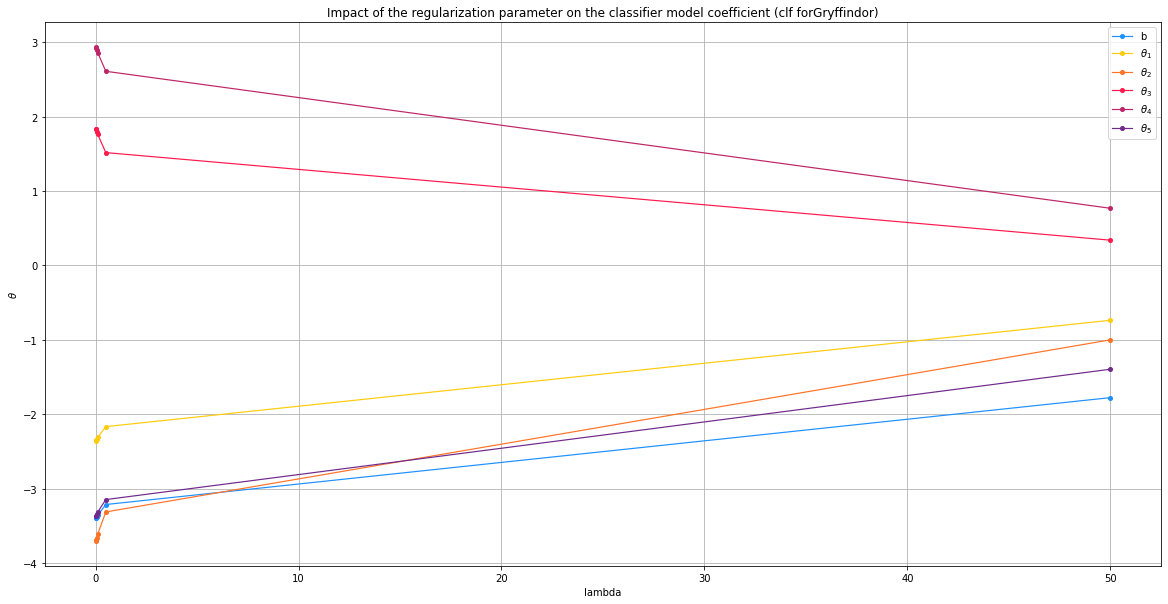

In [73]:
fig, axes = plt.subplots(1,1,figsize=(20,10))
#gs = GridSpec(4, 1, figure=fig)
#axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]

# --formatting the different axes -- #
axes.set_title("Impact of the regularization parameter on the classifier model coefficient (clf forGryffindor)")
axes.set_xlabel("lambda")
axes.set_ylabel(r"$\theta$")
axes.grid()

# -- plot for the fist axe (non standardized data)
color = ["dodgerblue", "#FFCC0D", "#FF7326", "#FF194D", "#BF2669", "#702A8C"]
    
axes.plot(lambdas, bs, ls='-', marker='o', ms=4.0, lw=1.2, color=color[0], label="b")
axes.plot(lambdas, thetas_1, ls='-', marker='o', ms=4.0, lw=1.2, color=color[1], label=r"$\theta_1$")
axes.plot(lambdas, thetas_2, ls='-', marker='o', ms=4.0, lw=1.2, color=color[2], label=r"$\theta_2$")
axes.plot(lambdas, thetas_3, ls='-', marker='o', ms=4.0, lw=1.2, color=color[3], label=r"$\theta_3$")
axes.plot(lambdas, thetas_4, ls='-', marker='o', ms=4.0, lw=1.2, color=color[4], label=r"$\theta_4$")
axes.plot(lambdas, thetas_5, ls='-', marker='o', ms=4.0, lw=1.2, color=color[5], label=r"$\theta_5$")

axes.legend()

# -- Displaying the plot -- #
plt.show()

## Conclusion:
La régularisation ne semble pas affectée les performances du modèle (*accuracy*, *precision*, *recall* et *F1-score*), du moins dans l'intervalle de valeur étudié.
Les performances (*accuracy*, *precision*, *recall* et *F1-score*) sont identiques pour des valeurs de paramètre de régularisation parmi ($0.01$, $0.05$, $0.1$, $0.5$ et $50$)
À titre de vérification, nous constatons bien que la régularisation affecter les valeurs des paramètres des classifieurs.